# AMAZON APPAREL RECOMMENDATIONS

## Overview of the Data

## Import the required libraries

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

## Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Data

In [3]:
data = pd.read_json('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/tops_fashion.json')

In [4]:
print ('Number of data points : ', data.shape[0],'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [5]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

## Load only required columns

In [6]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [7]:
print ('Number of data points : ', data.shape[0], 'Number of features:', data.shape[1])
data.head() 

Number of data points :  183138 Number of features: 7


asin  ... formatted_price
0  B016I2TS4W  ...            None
1  B01N49AI08  ...            None
2  B01JDPCOHO  ...            None
3  B01N19U5H5  ...            None
4  B004GSI2OS  ...          $26.26

[5 rows x 7 columns]

In [8]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [9]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [10]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

# Find Basic Stats for the Feature : Brand

In [11]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [12]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

# Find Basic Stats for the Feature : Color

In [13]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [14]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

# Find Basic Stats for the Feature : formatted_price

In [15]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [16]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

# Find Basic Stats for the Feature : title

In [17]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [18]:
data.to_pickle('./180k_apparel_data')

In [19]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [20]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


# Remove the duplicates

## Understand about the Duplicates

In [21]:
data = pd.read_pickle('/content/180k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

7153


In [22]:
data.head()

asin  ... formatted_price
0  B016I2TS4W  ...            None
1  B01N49AI08  ...            None
2  B01JDPCOHO  ...            None
3  B01N19U5H5  ...            None
4  B004GSI2OS  ...          $26.26

[5 rows x 7 columns]

In [23]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 178026


In [24]:
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin  ... formatted_price
27547  B073W7P8KK  ...            None
31277  B01M0PWMZ8  ...            None
30453  B01M02GWRG  ...            None
32485  B01N0ADXM0  ...            None
26767  B01MTQAU86  ...            None

[5 rows x 7 columns]

In [25]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [26]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])


            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [27]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [28]:
print('Number of data points : ', data.shape[0])

Number of data points :  151251


# Text Preprocessing

In [29]:
data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/pickels/16k_apperal_data')

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'again', "that'll", "you've", 'itself', 'what', 'than', 's', 'off', "you'd", 'is', 't', 'on', 'haven', 'some', 'her', 'before', 'where', 'are', 'this', 'ma', 'when', 'why', 'y', 'until', 'against', 'am', "mightn't", "you're", 'theirs', 'then', 'themselves', 'yours', 'how', 'hasn', 'we', 'too', 'myself', 'your', 'and', 'by', 'have', "haven't", "it's", 'she', 'them', 'they', 'herself', 'our', 'such', 'yourselves', 'those', 'from', 'but', "wouldn't", "didn't", 'any', 'whom', 'i', 'once', 'hers', "you'll", 'or', 'up', 'there', 'with', "aren't", 'a', "shan't", 'that', 'needn', 'over', 'his', 'himself', 'aren', 'the', 'further', 'do', 'does', 'did', 'these', 'being', 'you', "hasn't", 'for', 'more', 'if', 'will', "needn't", 'few', 'below', 'to', 'can', 'hadn', 'wasn', 'between', 'own', 'were', 'having', 'been', 'don', "doesn't", "don't", "should've", 'couldn', 'under', 'weren', 'so', 'ours', 'should', 'now', 'each', 'wouldn', 'of', 'down', 'who', 'mightn', 'doesn', 'shoul

In [32]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

5.199537999999997 seconds


In [33]:
data.head()

asin  ... formatted_price
4   B004GSI2OS  ...          $26.26
6   B012YX2ZPI  ...           $9.99
15  B003BSRPB0  ...          $20.54
27  B014ICEJ1Q  ...           $7.39
46  B01NACPBG2  ...           $6.95

[5 rows x 7 columns]

# Stemming

In [53]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


# Text based product Similarity

In [54]:
data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/pickels/16k_apperal_data_preprocessed')
data.head()

asin  ... formatted_price
4   B004GSI2OS  ...          $26.26
6   B012YX2ZPI  ...           $9.99
15  B003BSRPB0  ...          $20.54
27  B014ICEJ1Q  ...           $7.39
46  B01NACPBG2  ...           $6.95

[5 rows x 7 columns]

In [55]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Apply Bag Of Words(BOW) on Product Titles

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

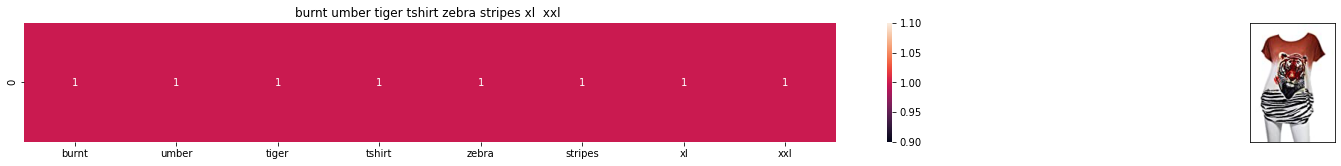

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


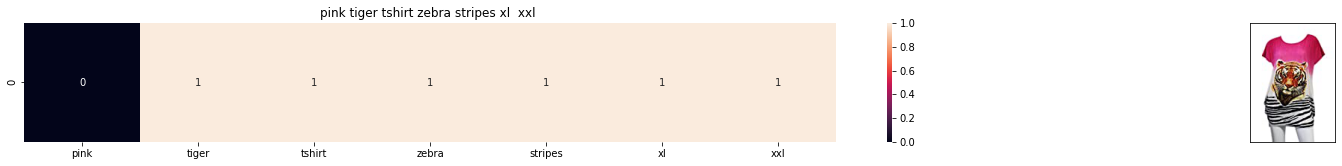

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


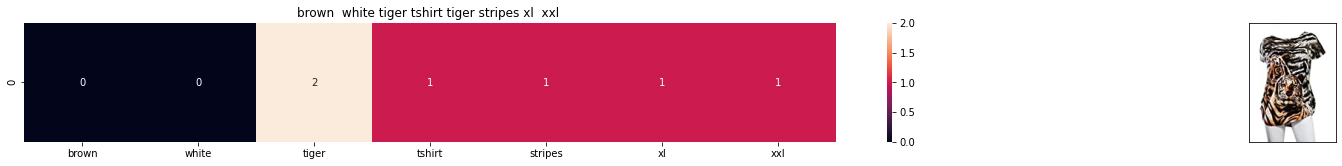

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


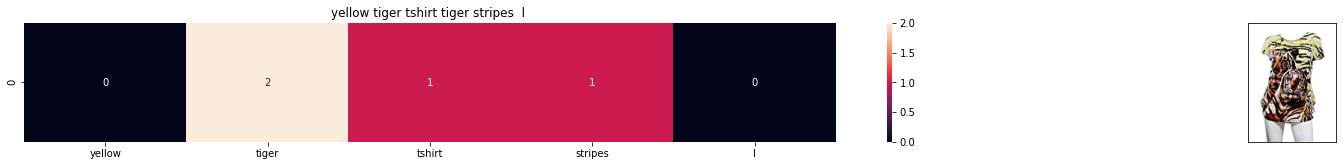

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


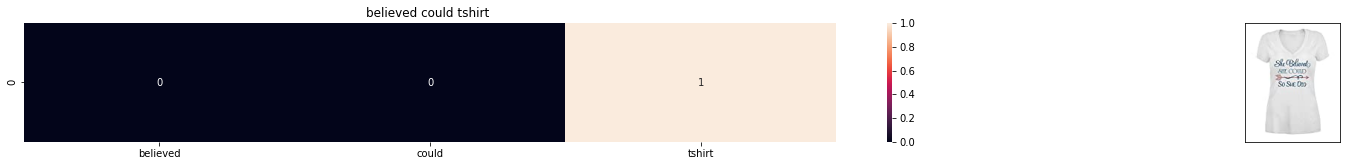

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


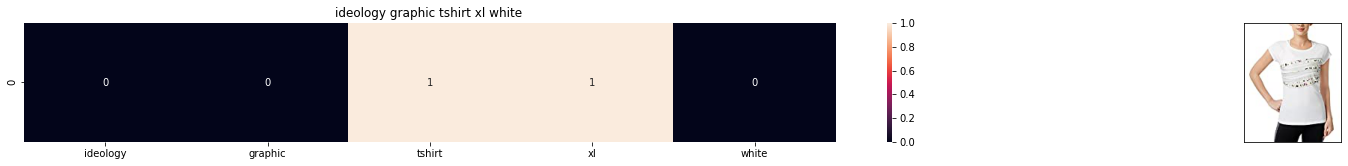

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


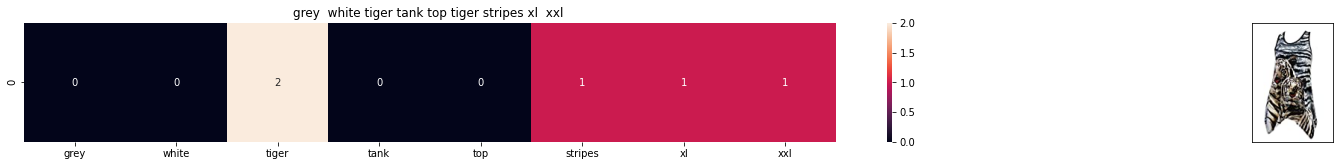

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


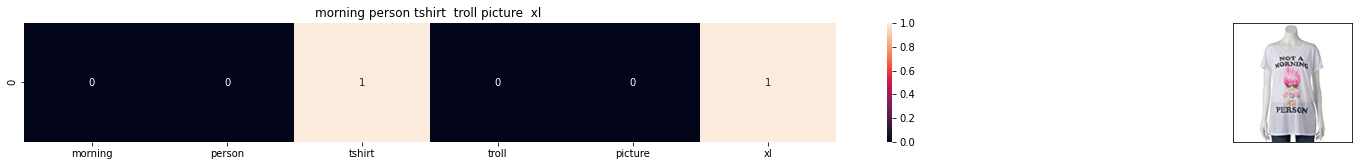

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


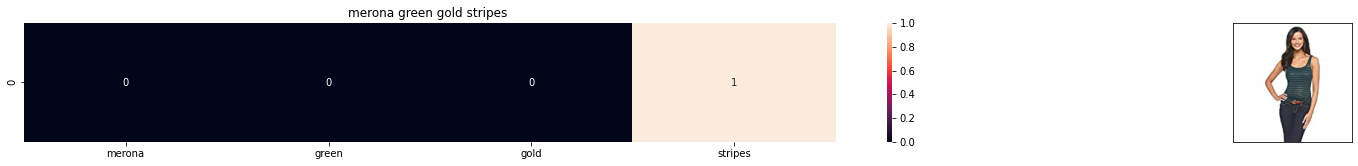

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


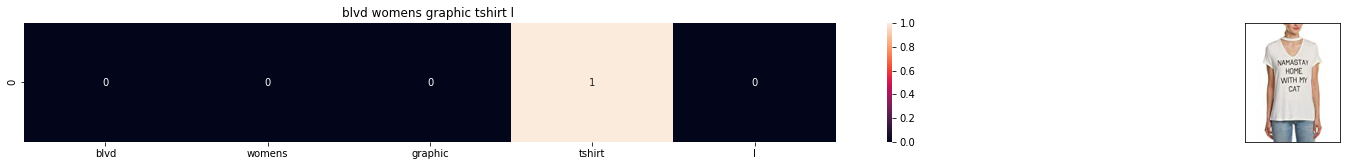

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


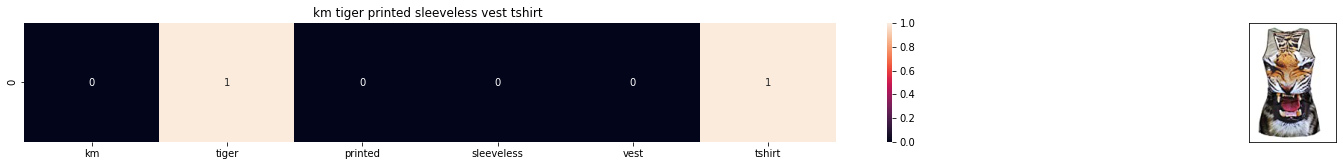

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.1622776601683795


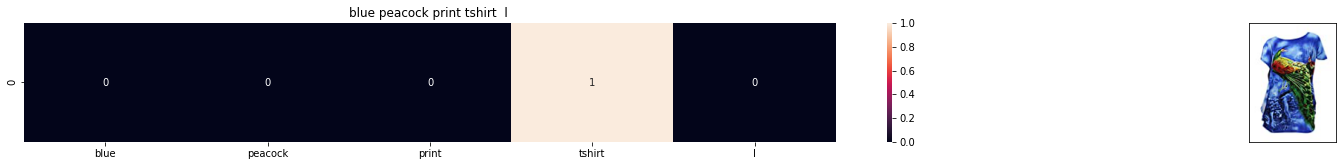

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


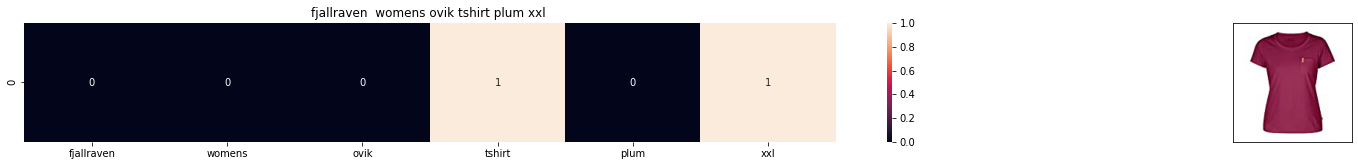

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795


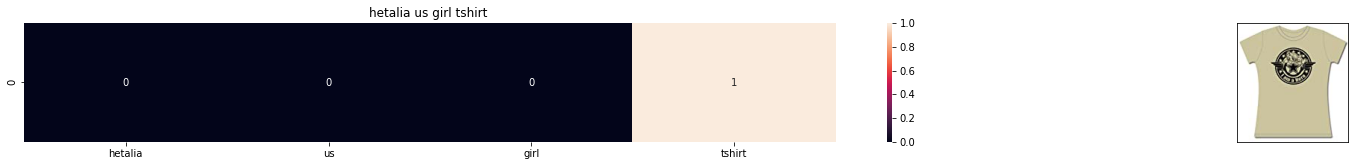

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795


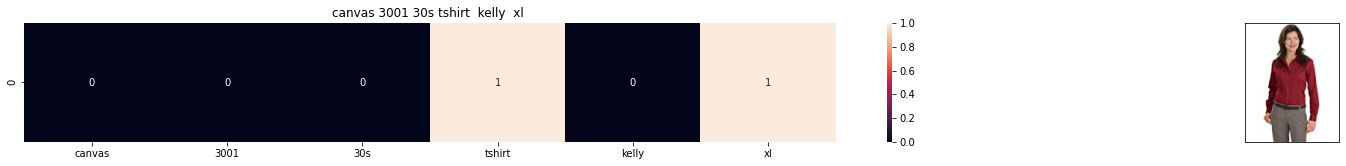

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.1622776601683795


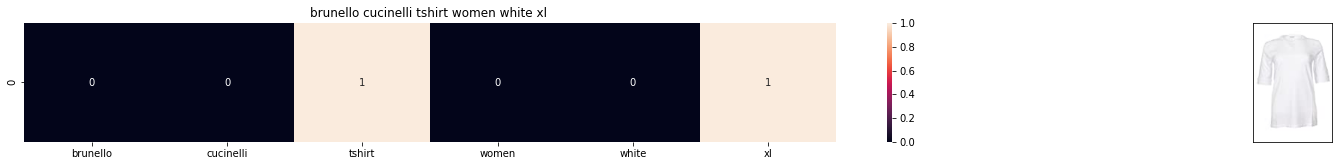

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.1622776601683795


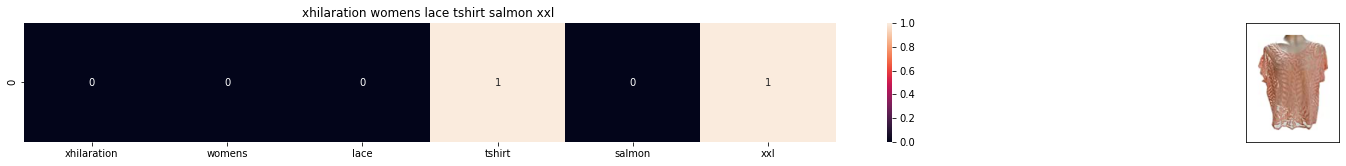

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.1622776601683795


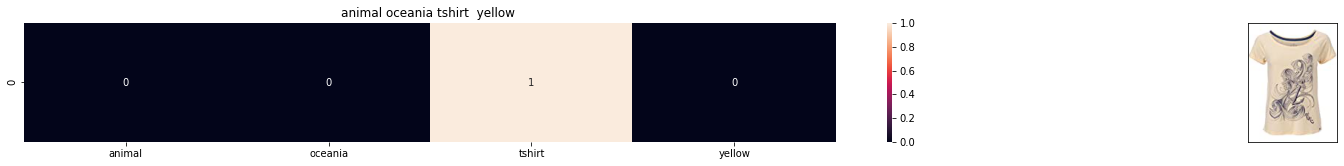

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.1622776601683795


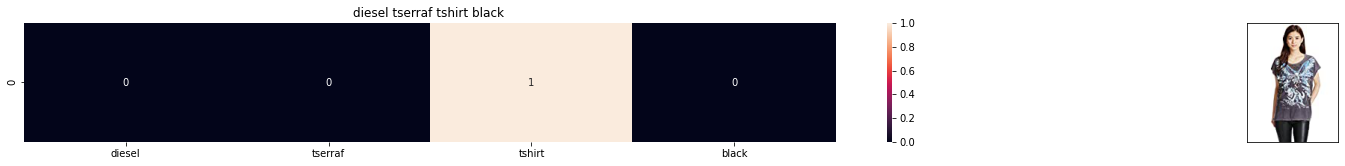

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795


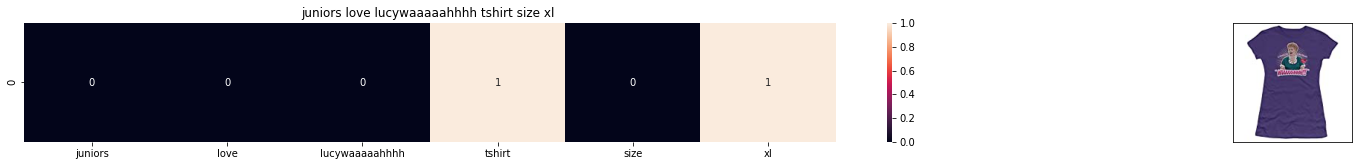

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795


In [72]:
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])        
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]    
    df_indices = list(data.index[indices])    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)


bag_of_words_model(12566, 20) # change the index if you want to.

# TFIDF based Product Similarity

In [73]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

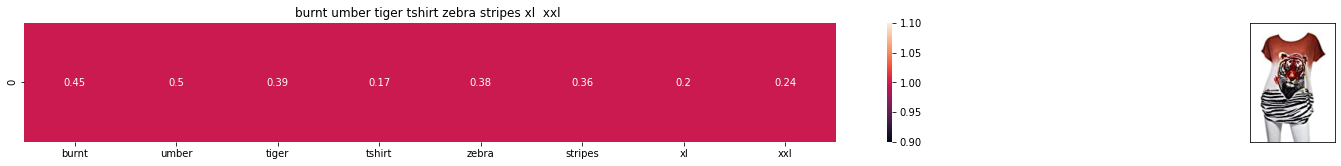

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


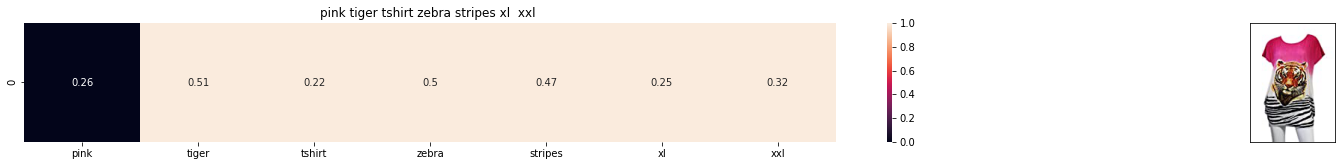

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451363


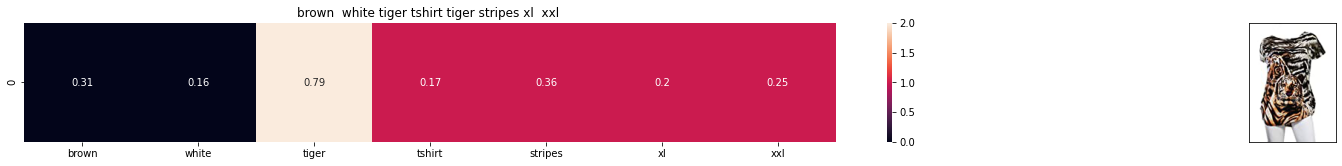

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769647


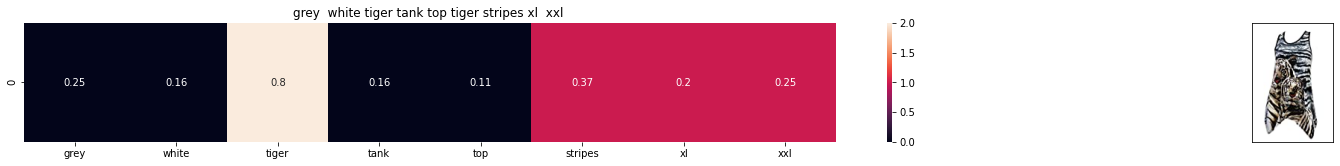

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


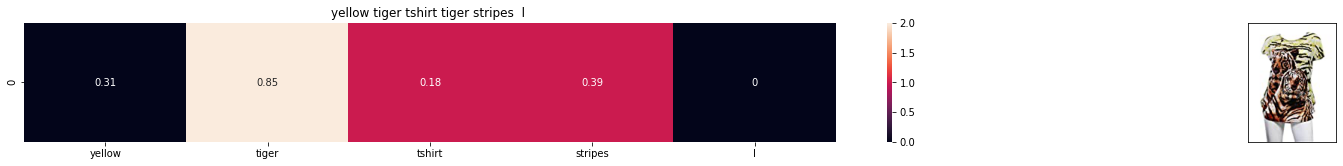

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


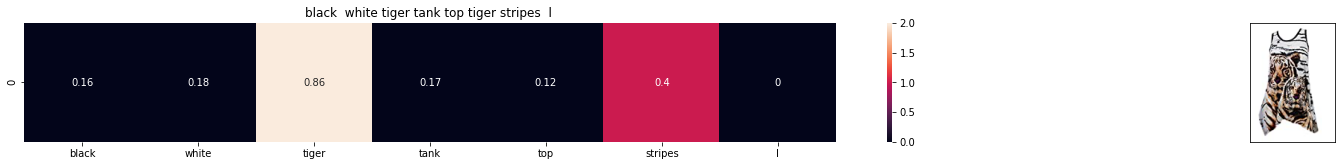

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


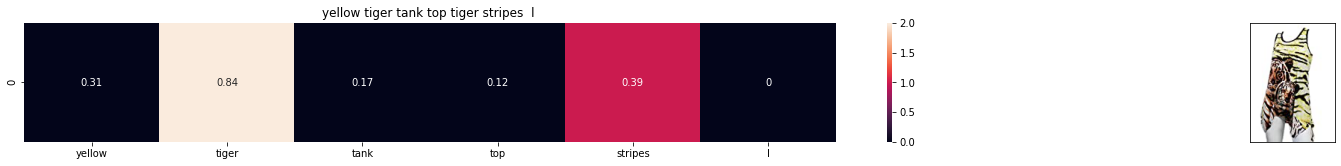

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


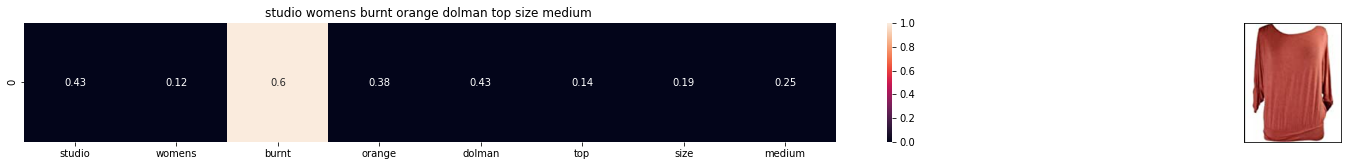

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


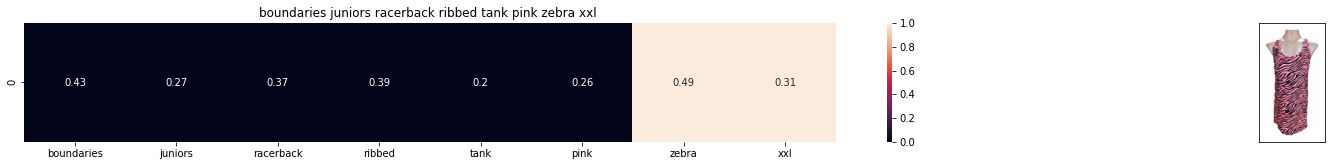

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.2121683810720831


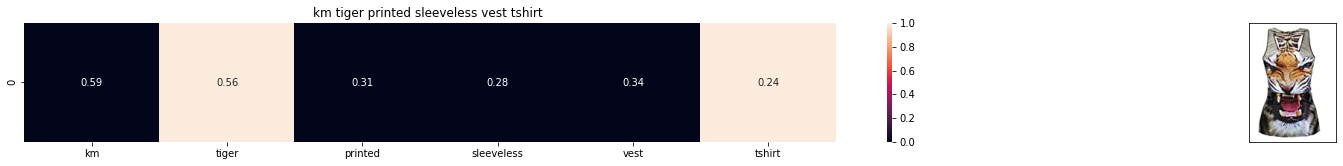

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


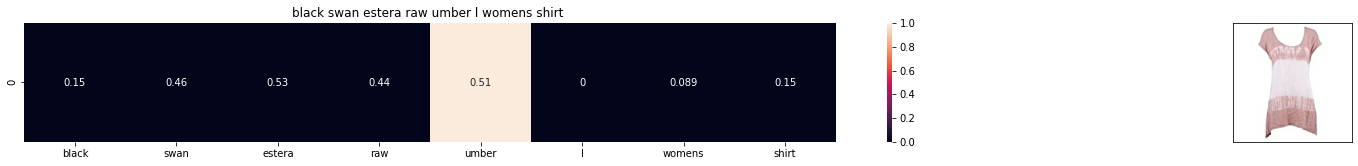

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


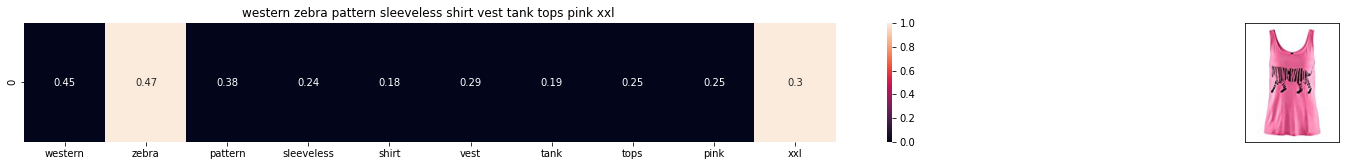

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


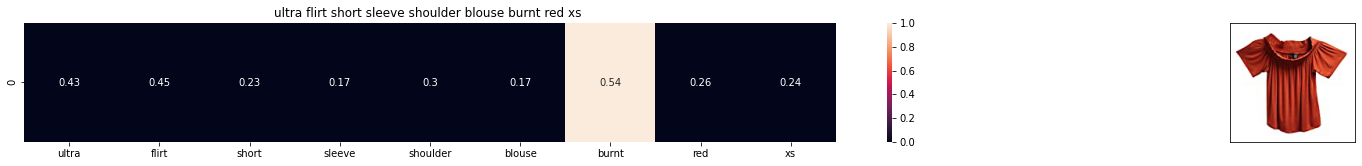

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


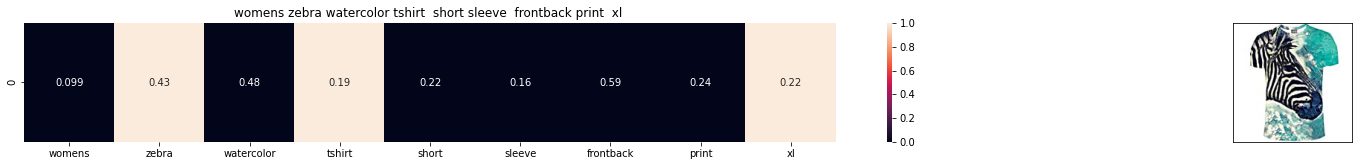

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624516


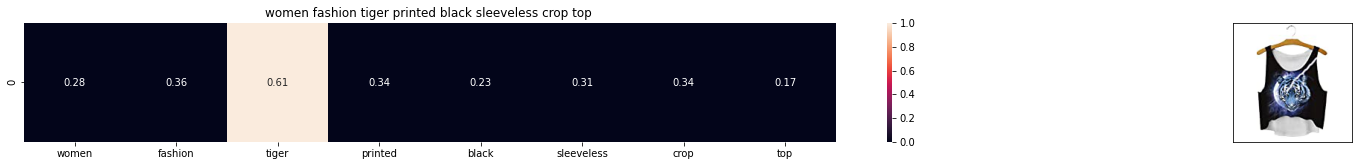

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


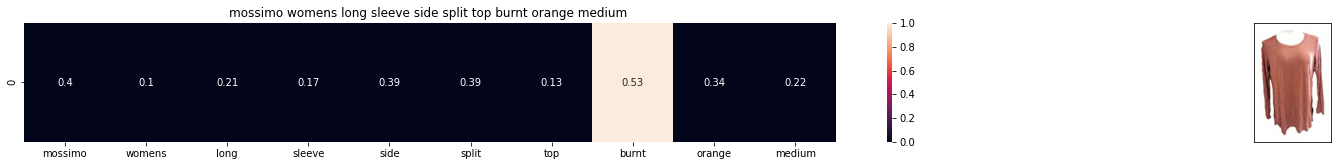

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


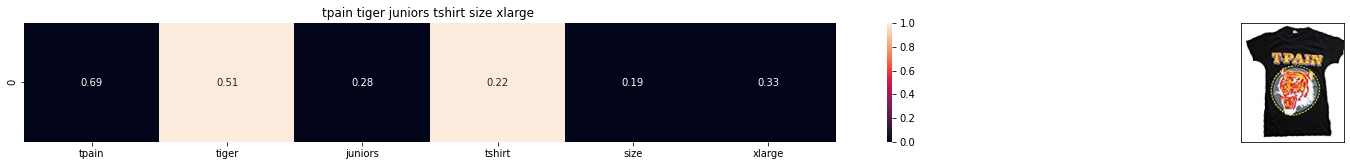

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


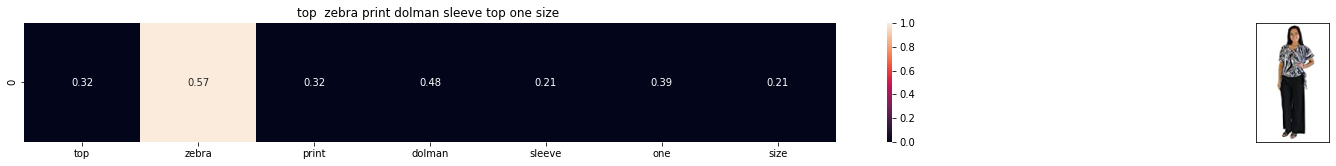

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


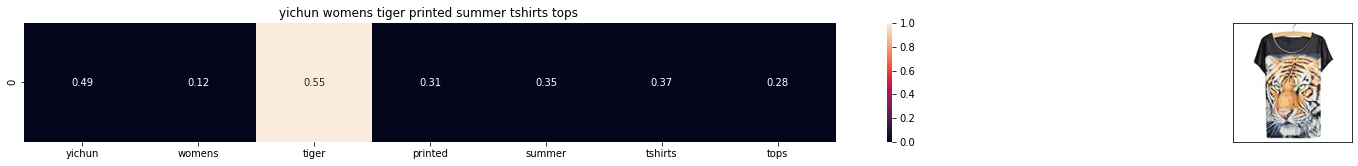

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.2535461420856102


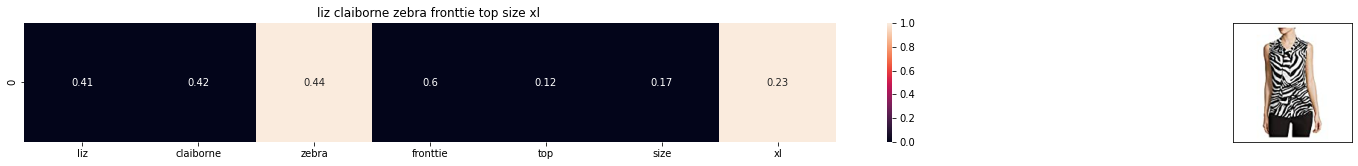

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [74]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)

# IDF Based Product Similarity

In [75]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [76]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [77]:
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

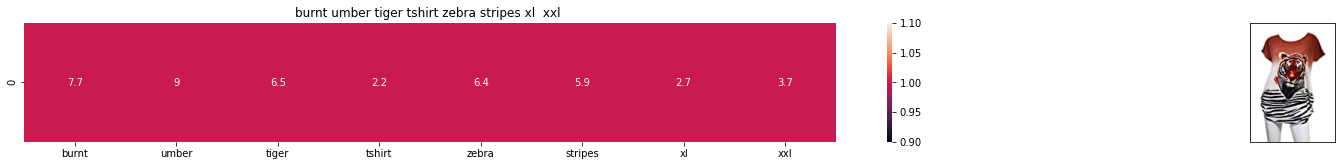

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from the given image : 0.0


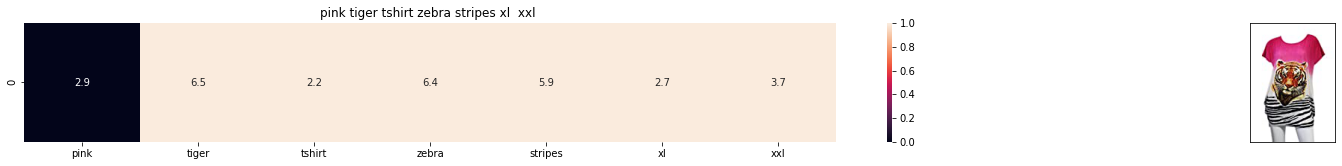

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 12.20507131122177


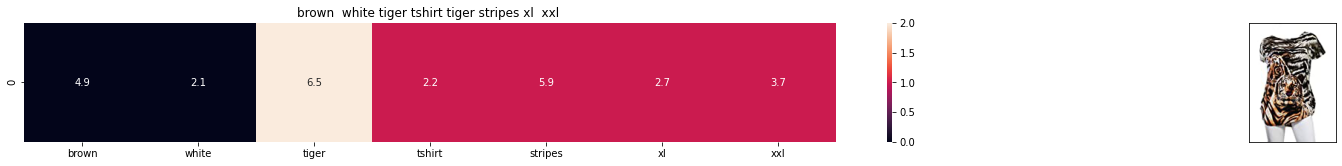

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 14.468362685603465


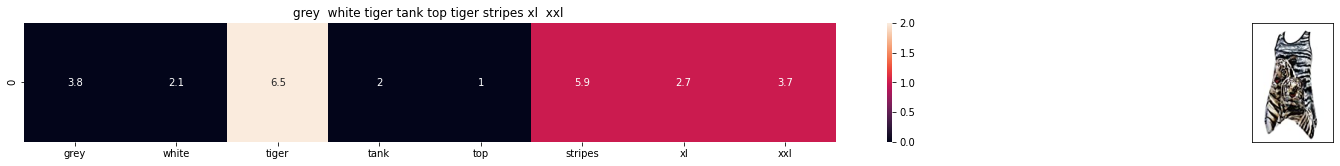

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 14.486832924778964


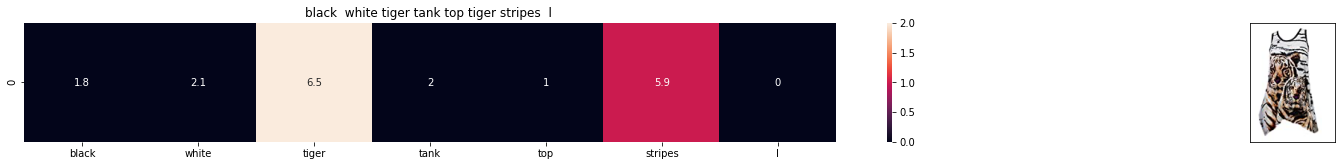

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from the given image : 14.833392966672909


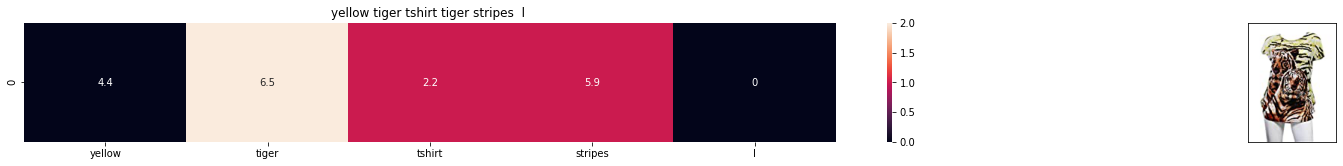

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from the given image : 14.898744516719225


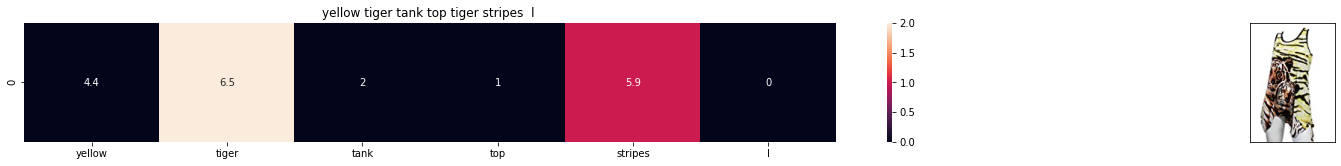

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from the given image : 15.224458287343769


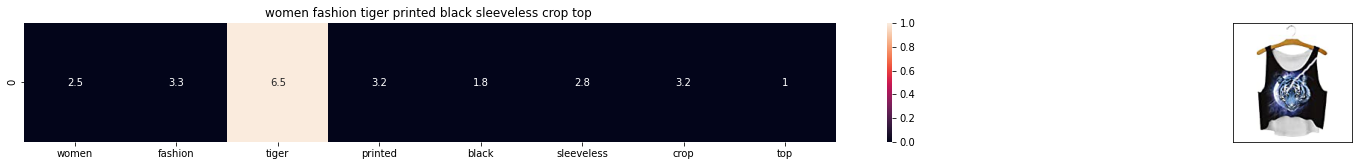

ASIN : B074T8ZYGX
Brand : MKP Crop Top
euclidean distance from the given image : 17.080812955631995


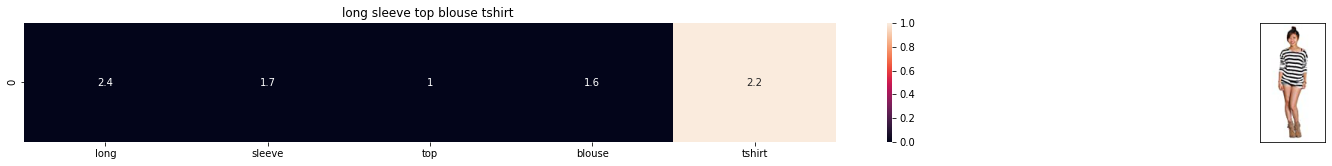

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 17.090168125645416


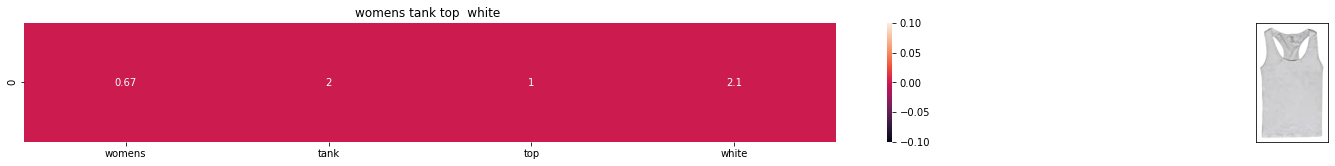

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 17.153215337562703


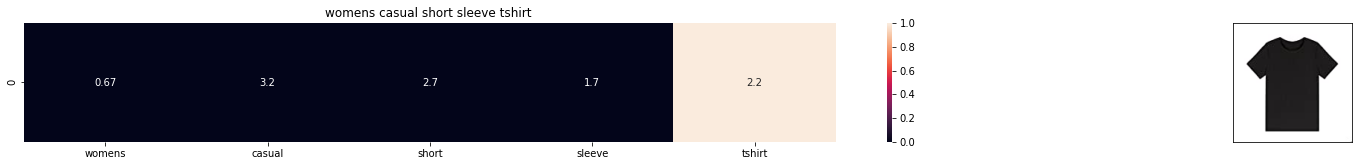

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 17.33671523874989


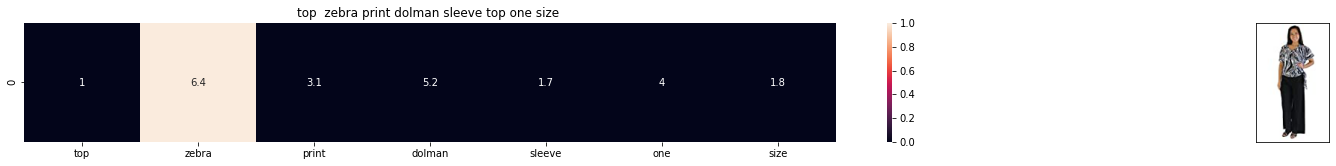

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from the given image : 17.410075941001253


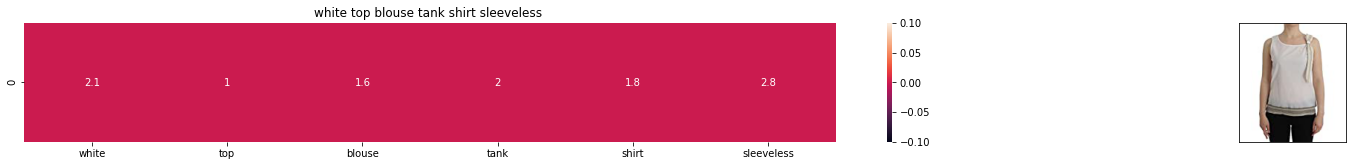

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 17.539921335459557


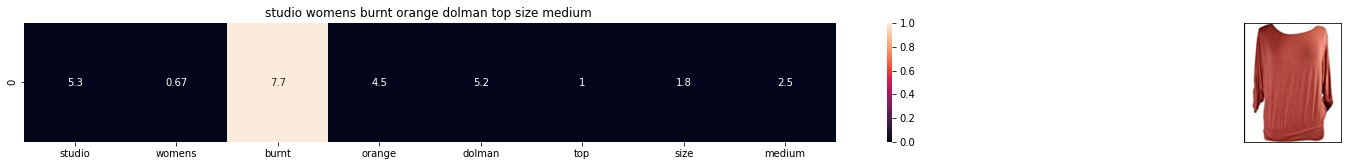

ASIN : B06XSCVFT5
Brand : Studio M
euclidean distance from the given image : 17.61275854366134


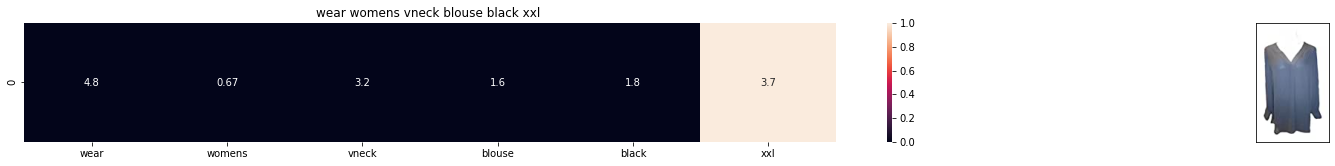

ASIN : B06Y6FH453
Brand : Who What Wear
euclidean distance from the given image : 17.623745282500135


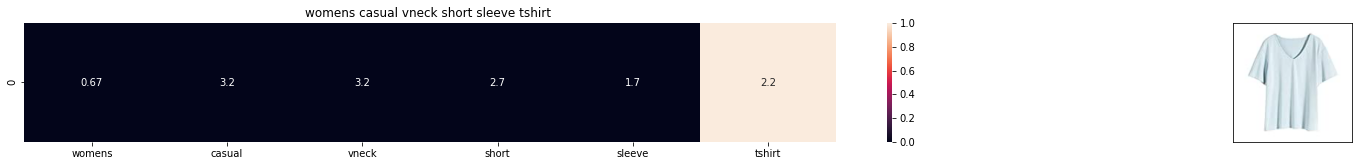

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 17.634342496835046


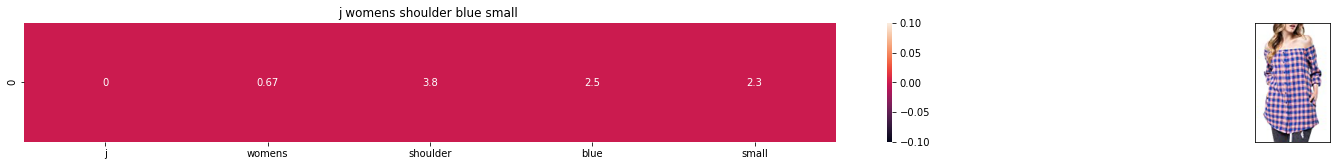

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 17.63753712743611


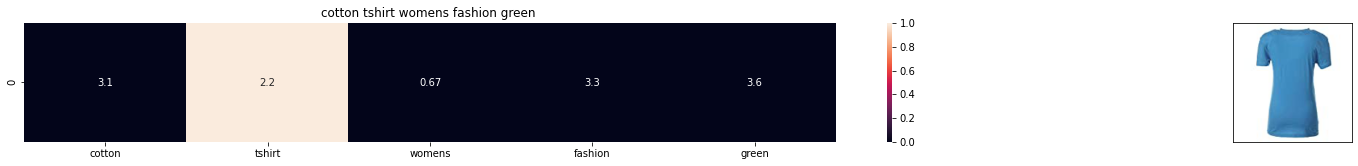

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 17.7230738913371


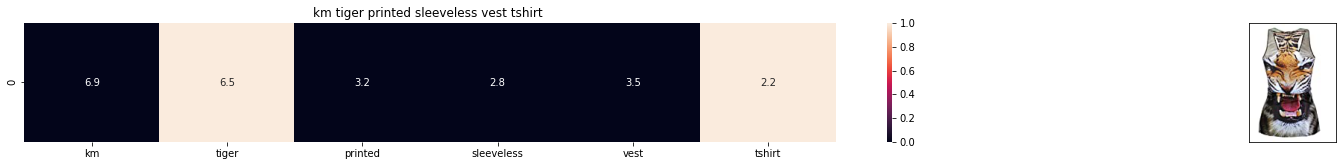

ASIN : B012VQLT6Y
Brand : KM T-shirt
euclidean distance from the given image : 17.762588561202364


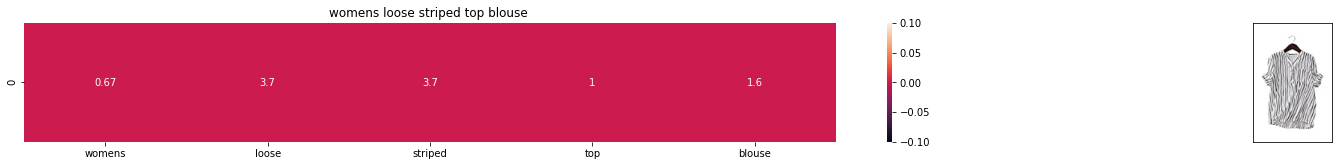

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 17.779536864674238


In [78]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)

# Text Semantics based product simiarity

In [79]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

with open('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [80]:
def get_word_vec(sentence, doc_id, m_name):
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
    
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)

def get_distance(vec1, vec2):
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [81]:
vocab = model.keys()

def build_avg_vec(sentence, num_features, doc_id, m_name):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

# Average Word2Vec Product Similarity

In [82]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

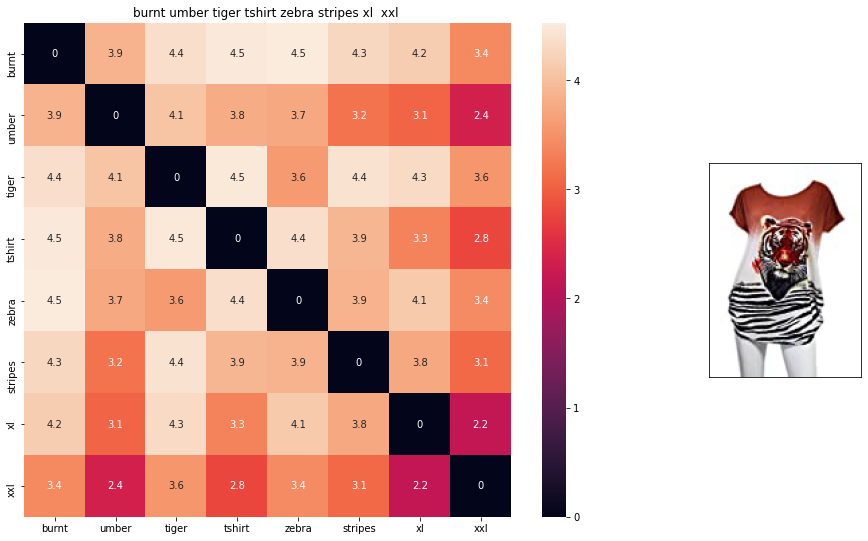

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.0


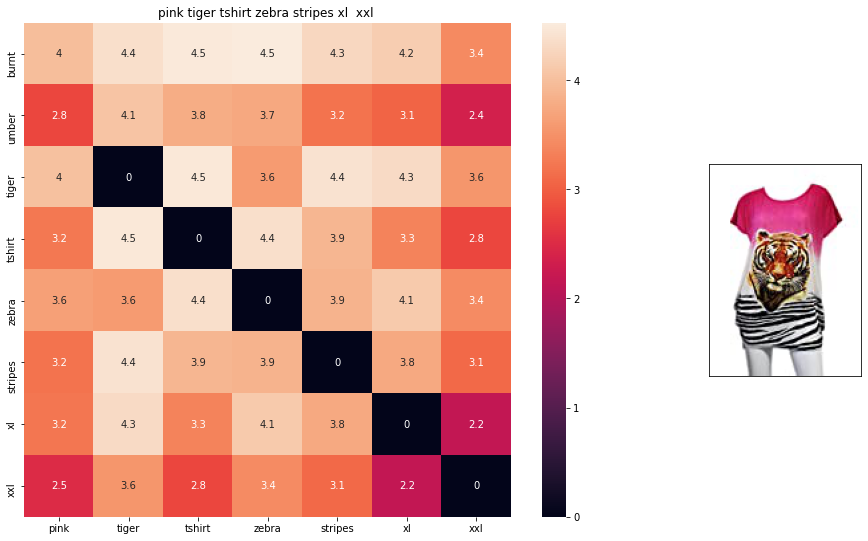

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891926


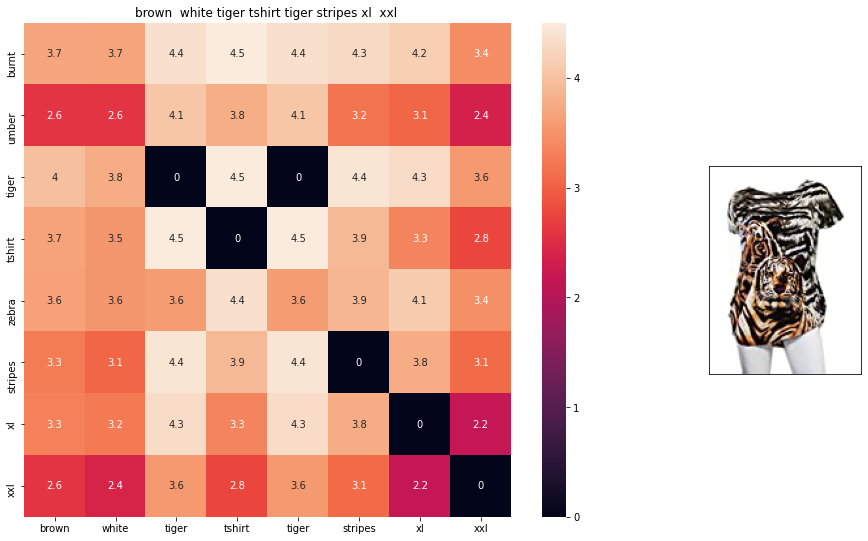

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003438


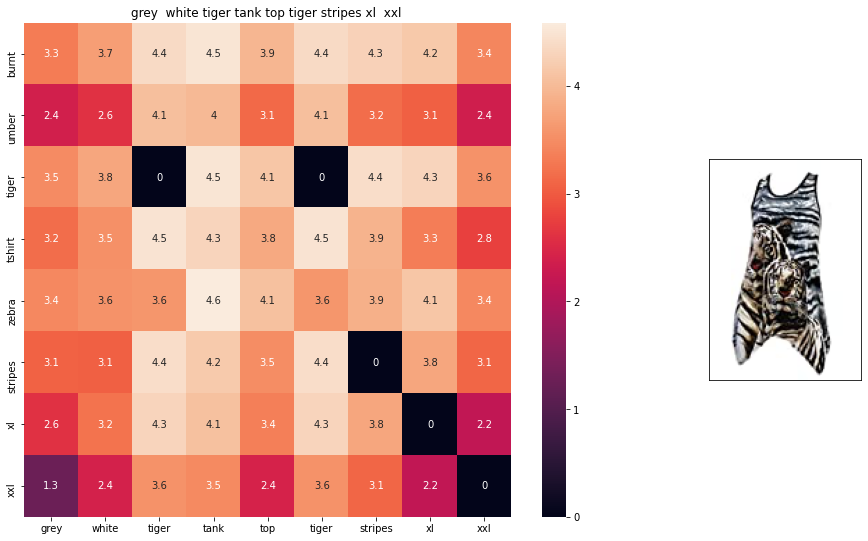

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.89283955


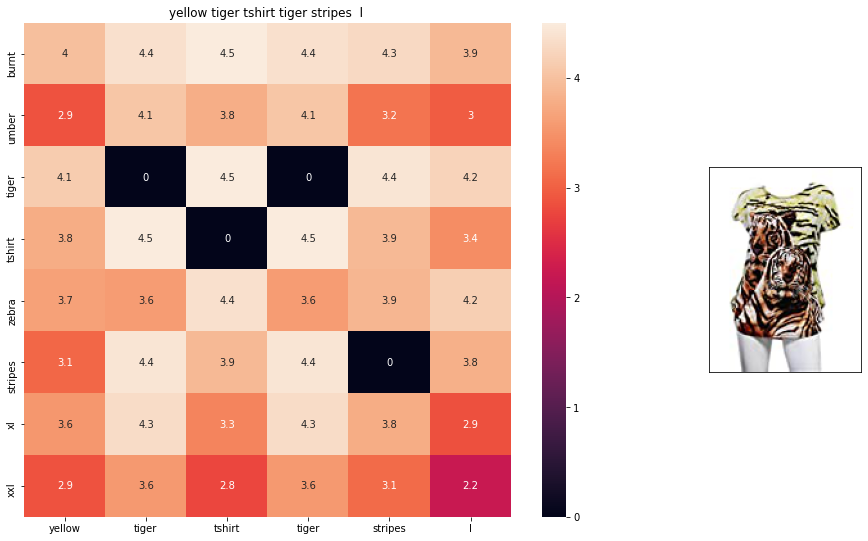

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601255


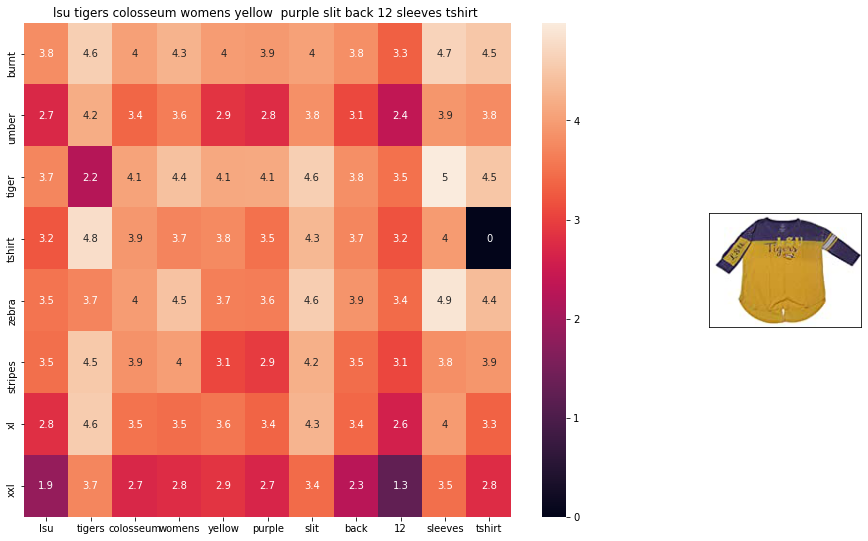

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.022969


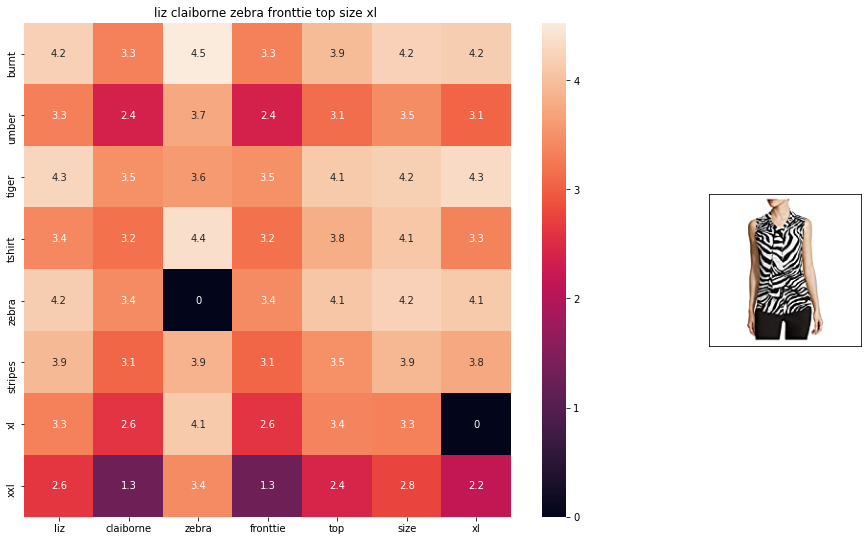

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


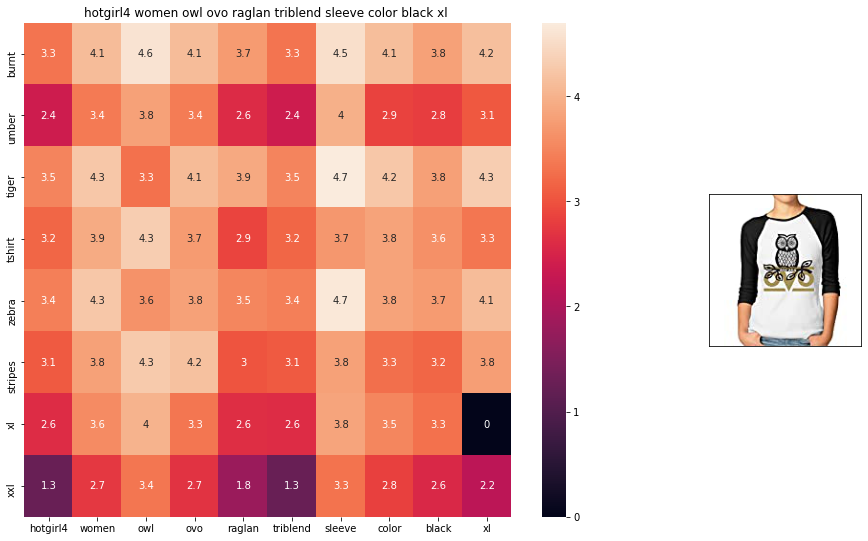

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405


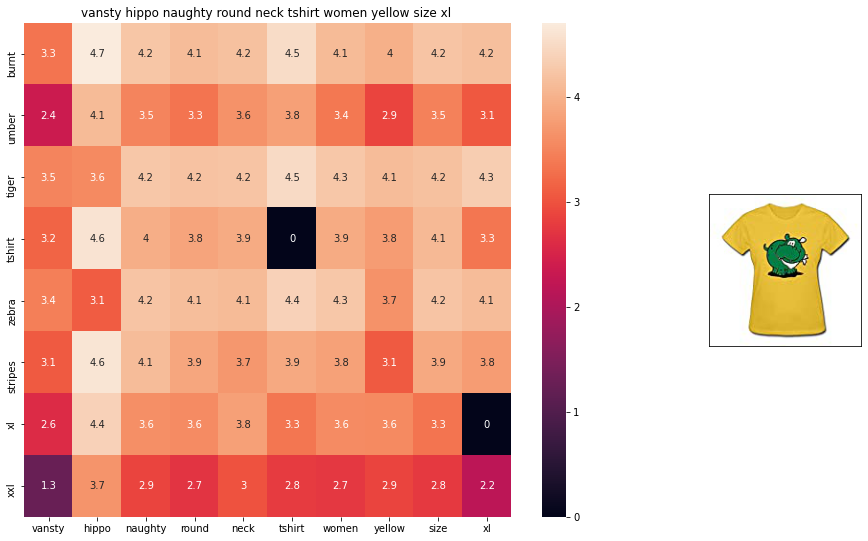

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


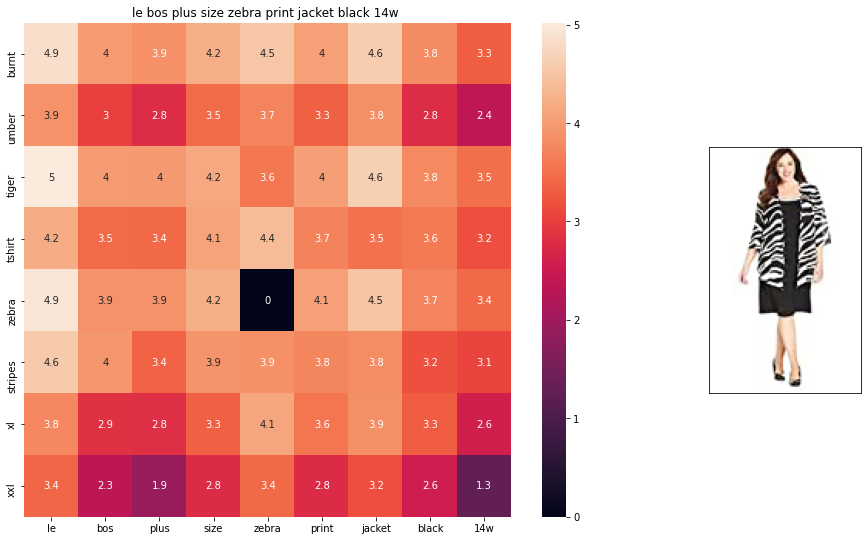

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839964


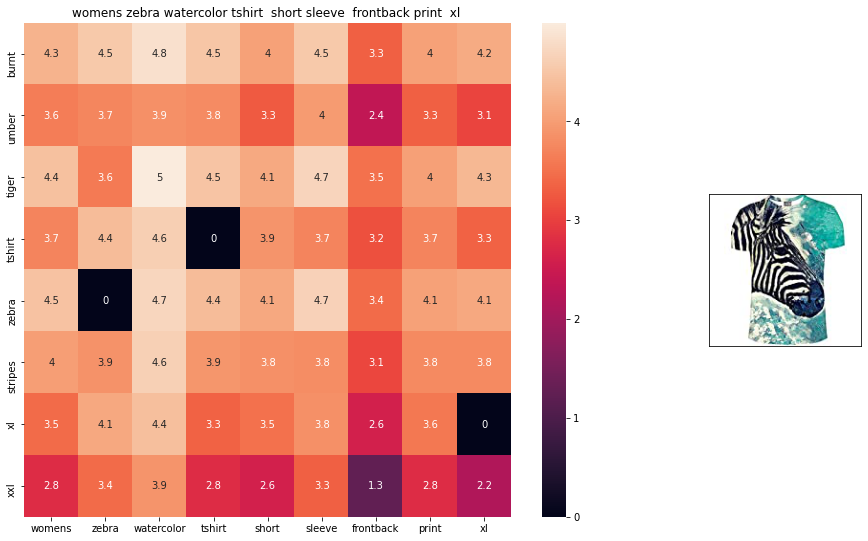

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842218


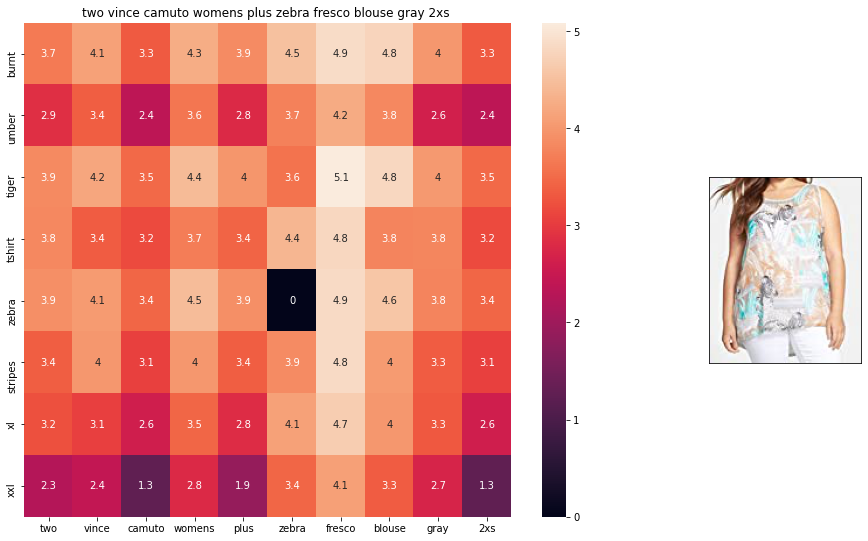

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895038


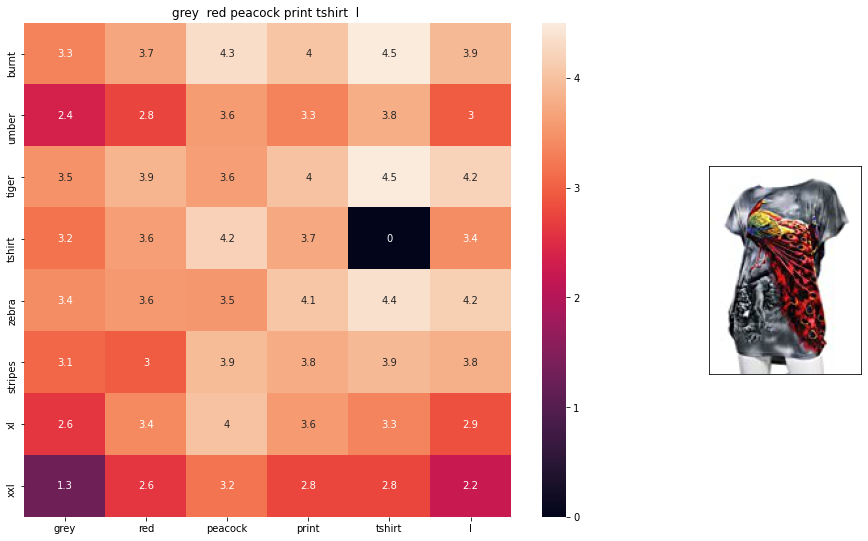

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588


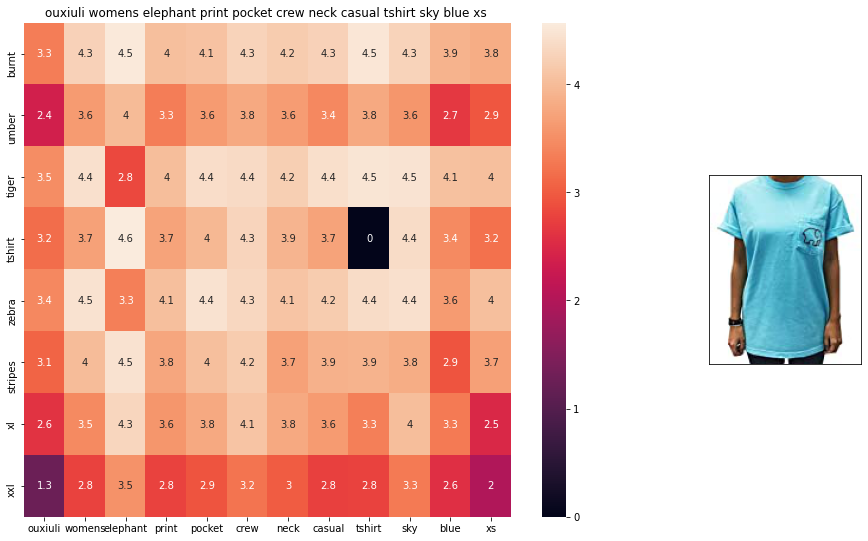

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920111


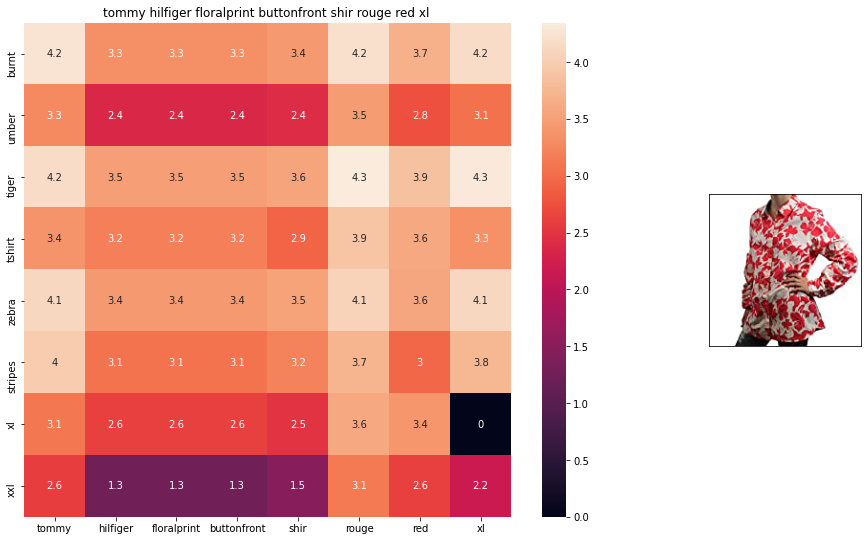

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923415


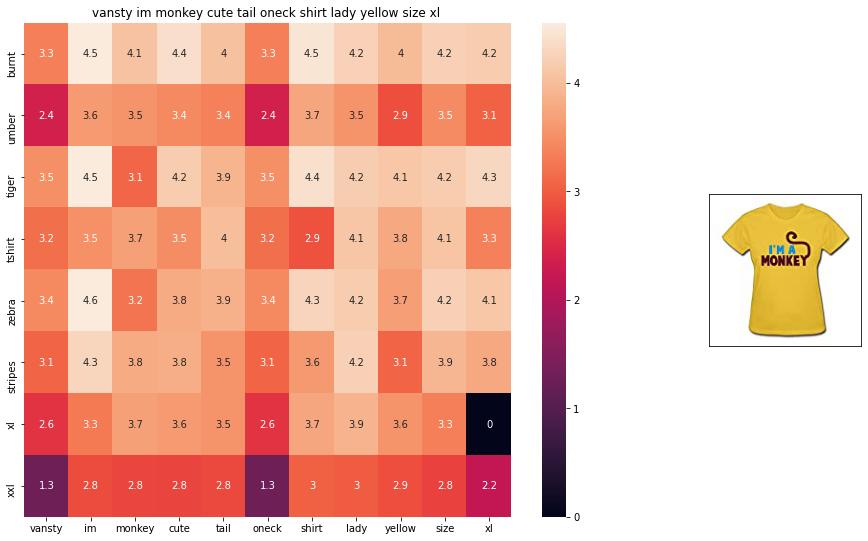

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934004


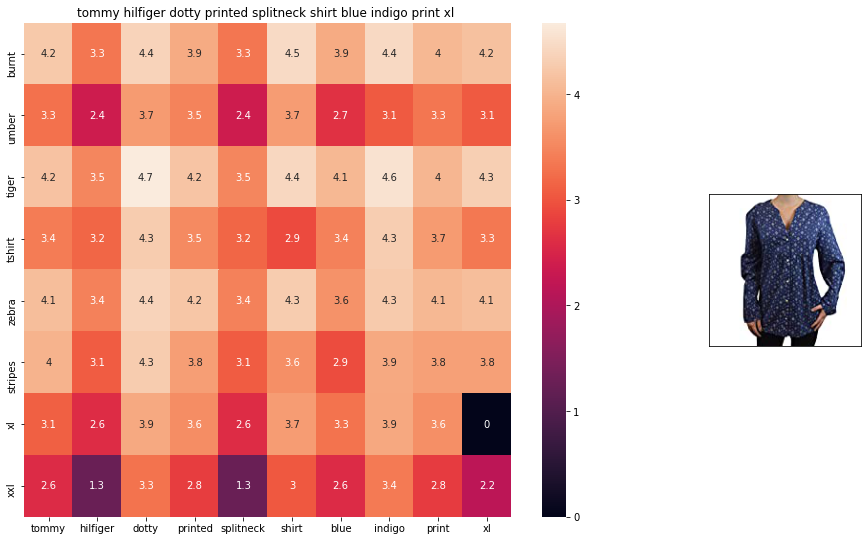

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942024


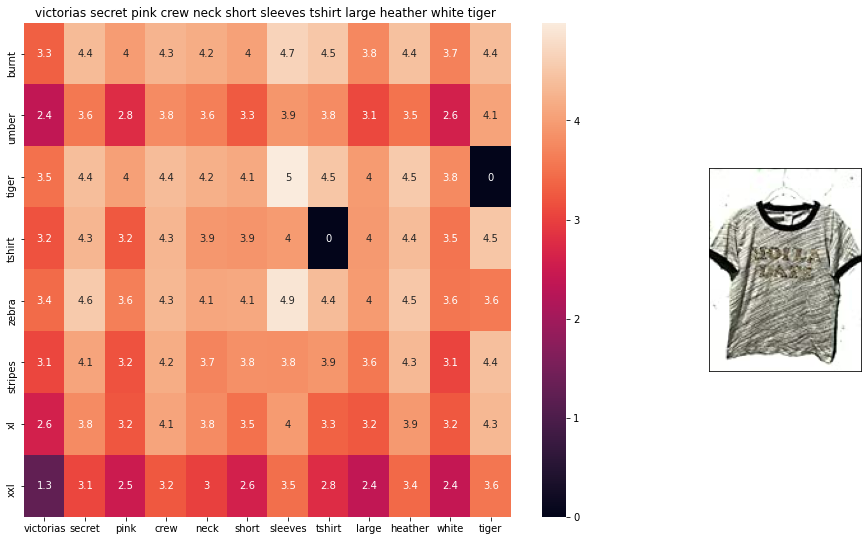

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948304


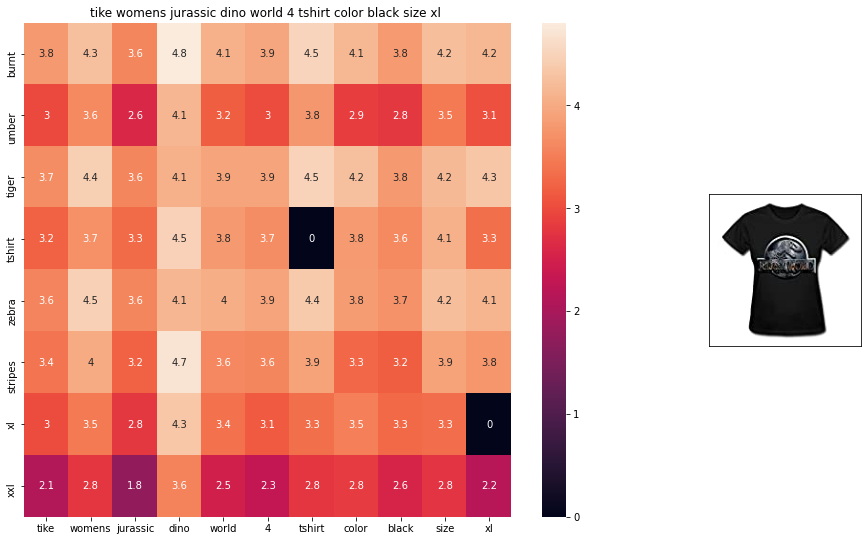

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275


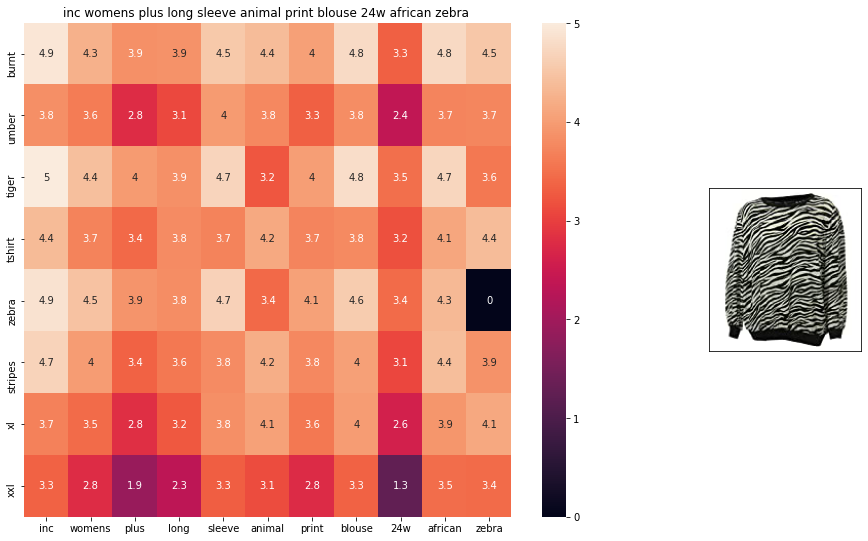

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966892


In [83]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)

# IDF Weighted Word2Vec for Product Similarity

In [84]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

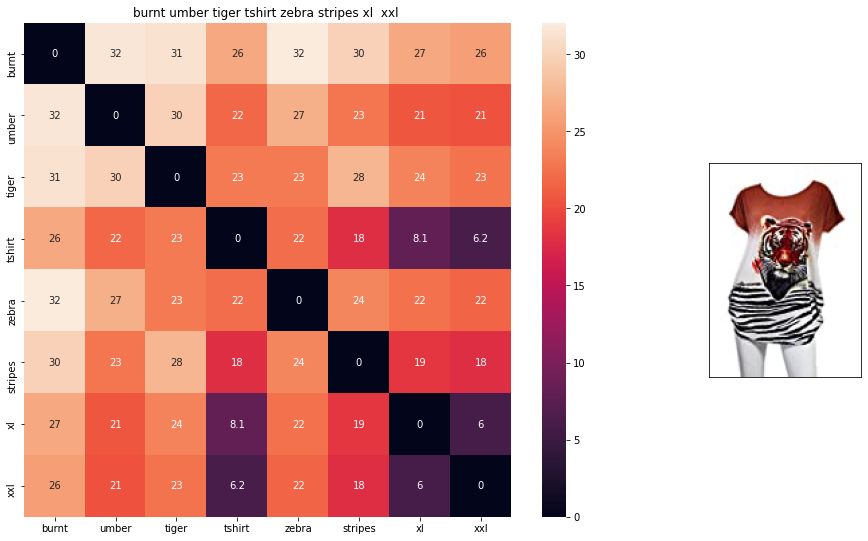

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


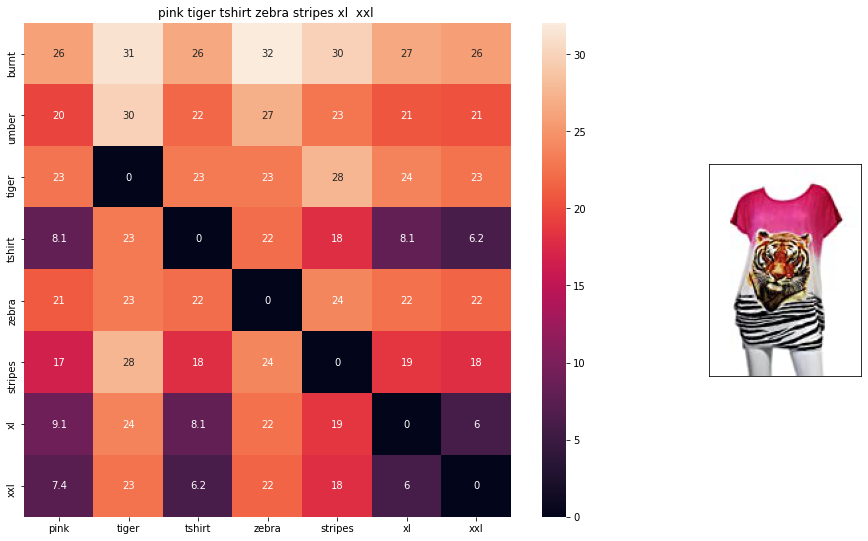

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.0638866


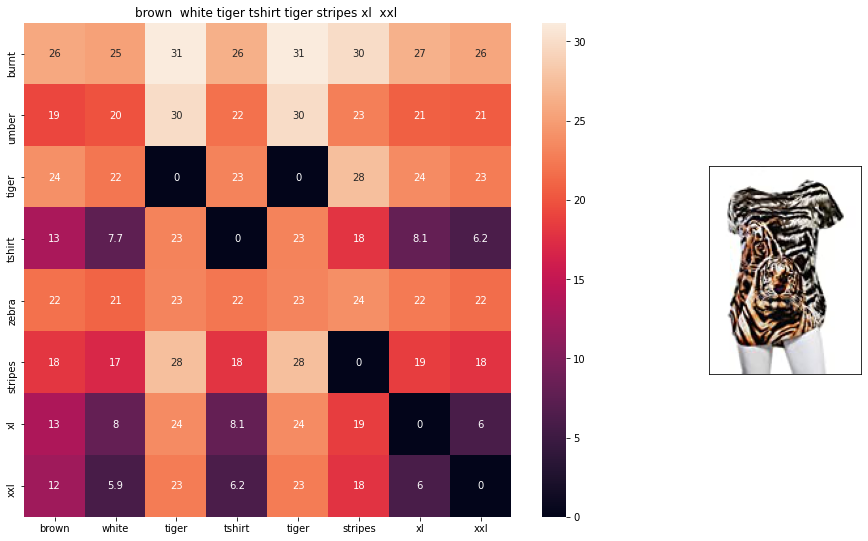

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.7709413


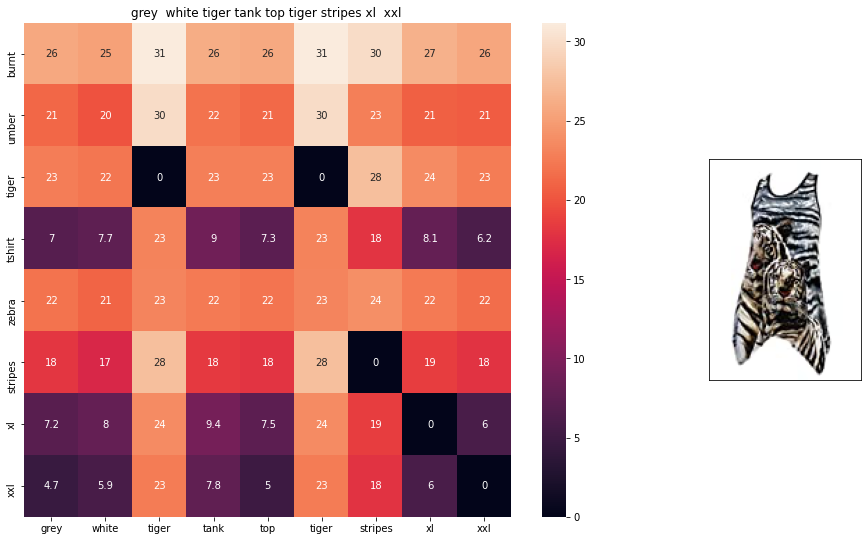

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.3601604


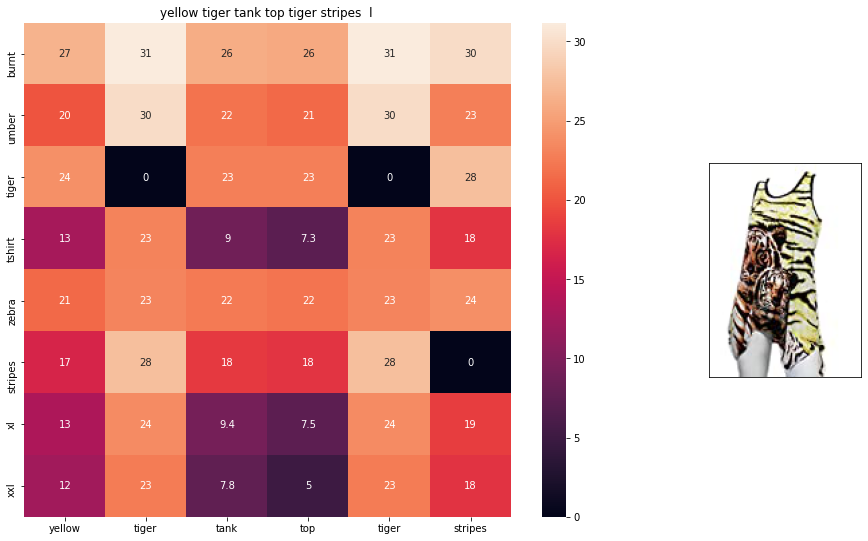

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.6895227


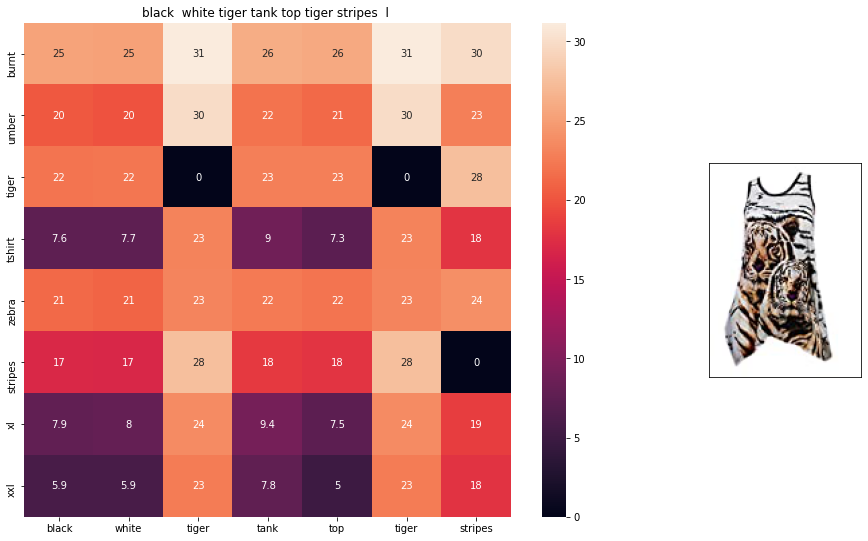

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.693021


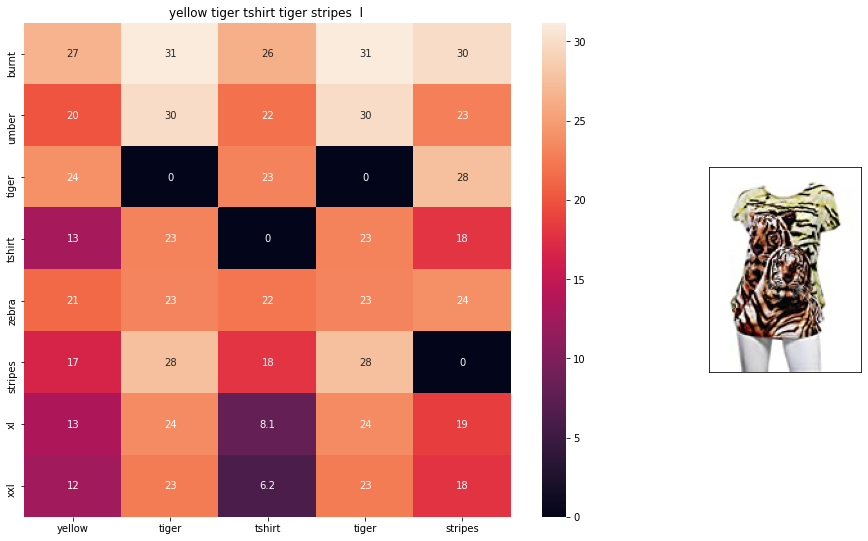

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.893442


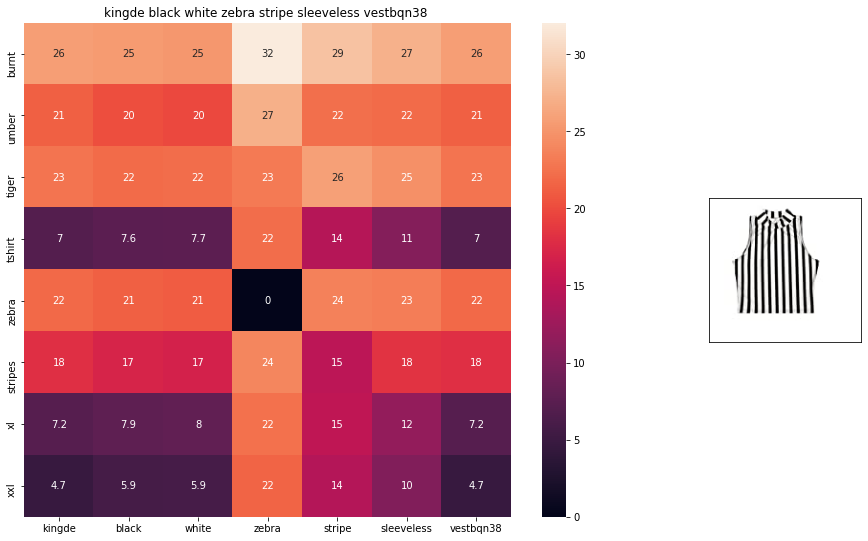

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.1329894


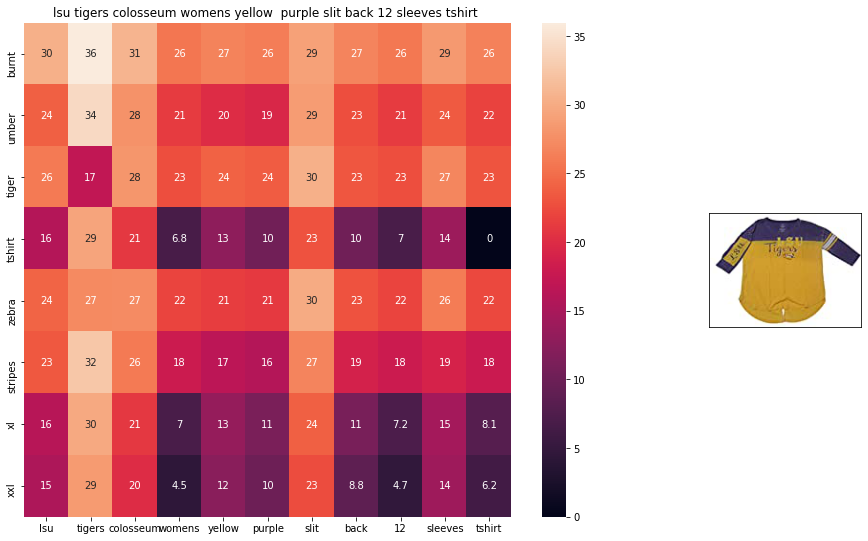

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.2567053


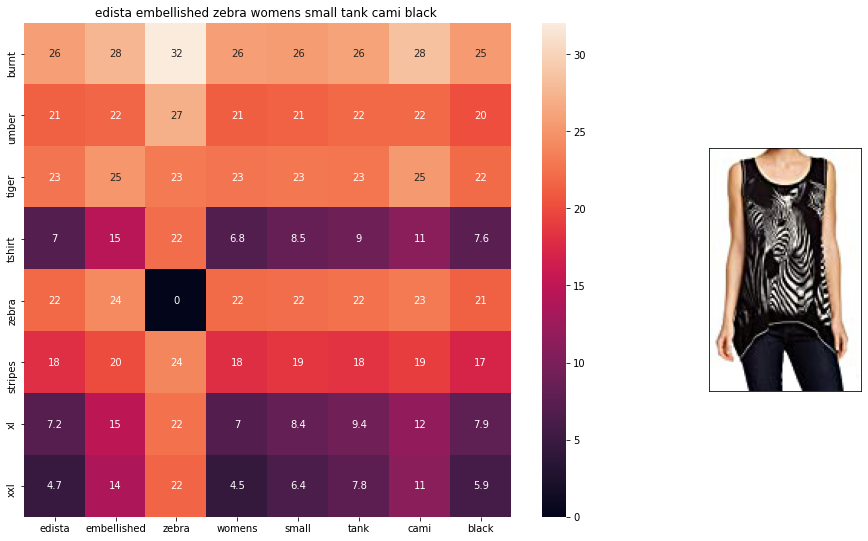

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.3922033


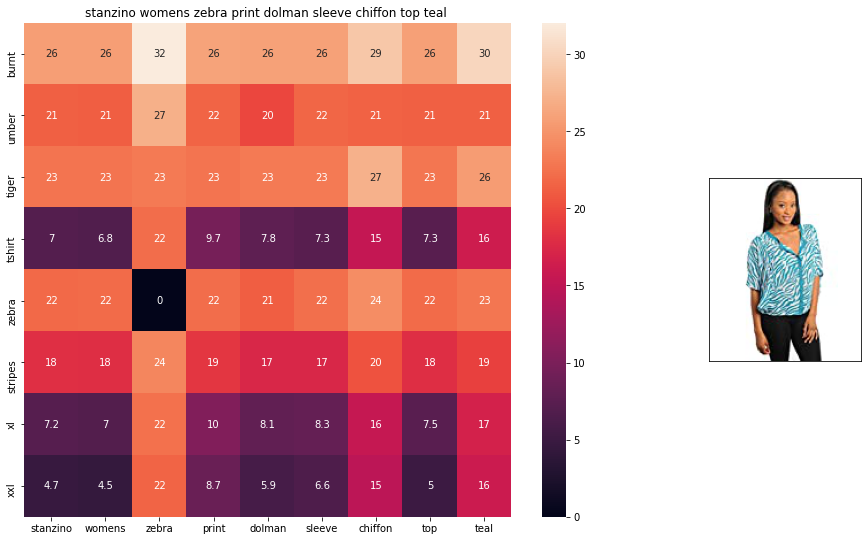

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 6.4149003


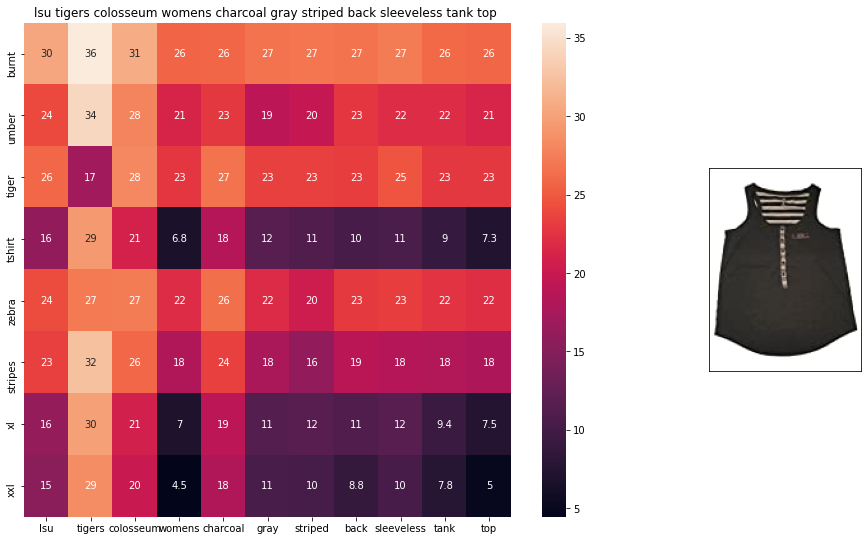

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 6.450959


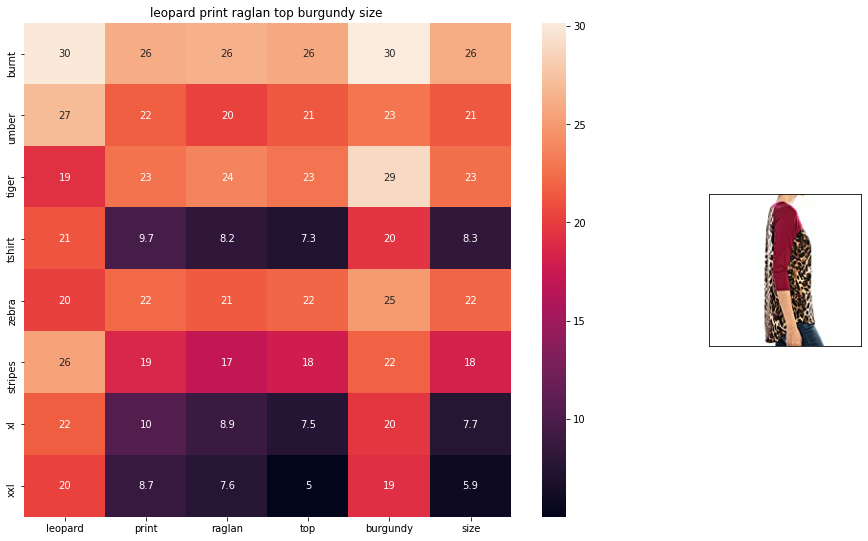

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 6.463409


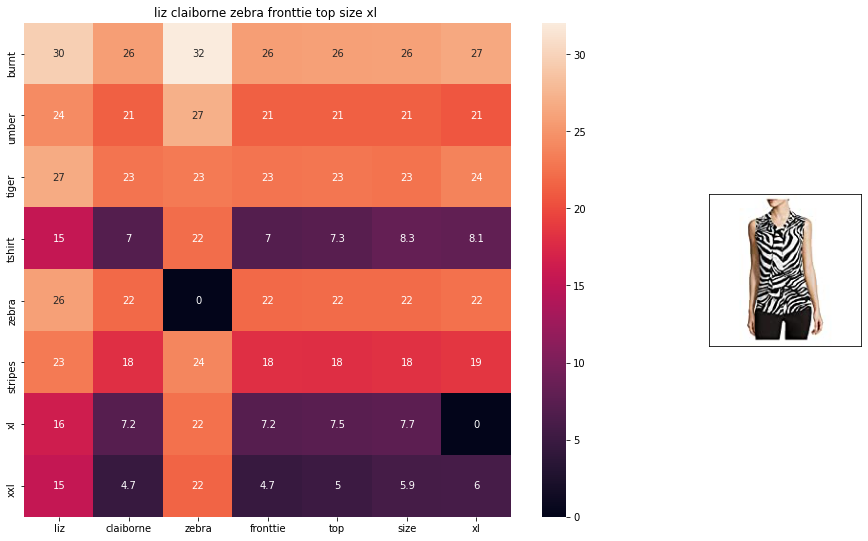

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 6.5392227


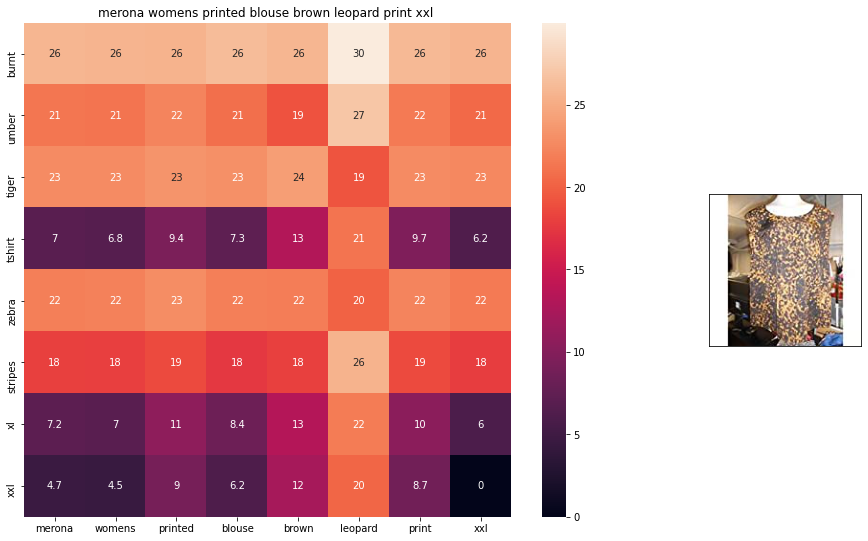

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 6.5755024


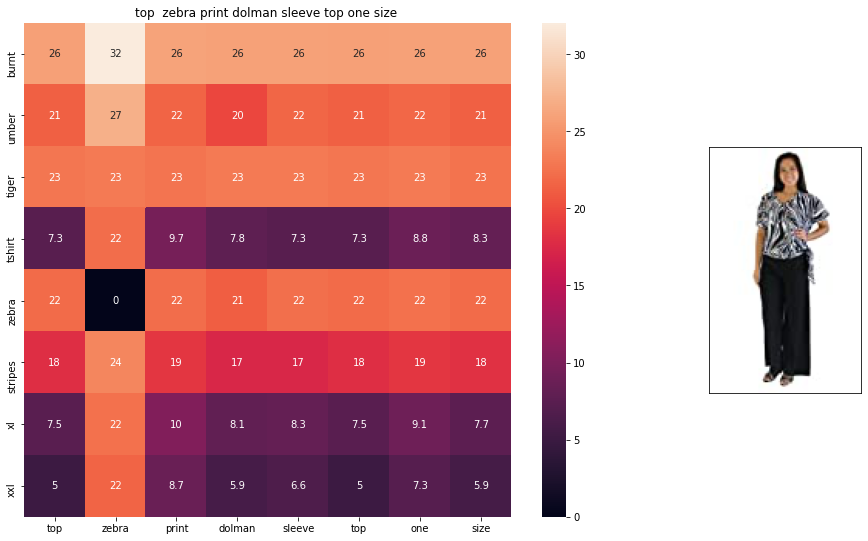

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from input : 6.6382146


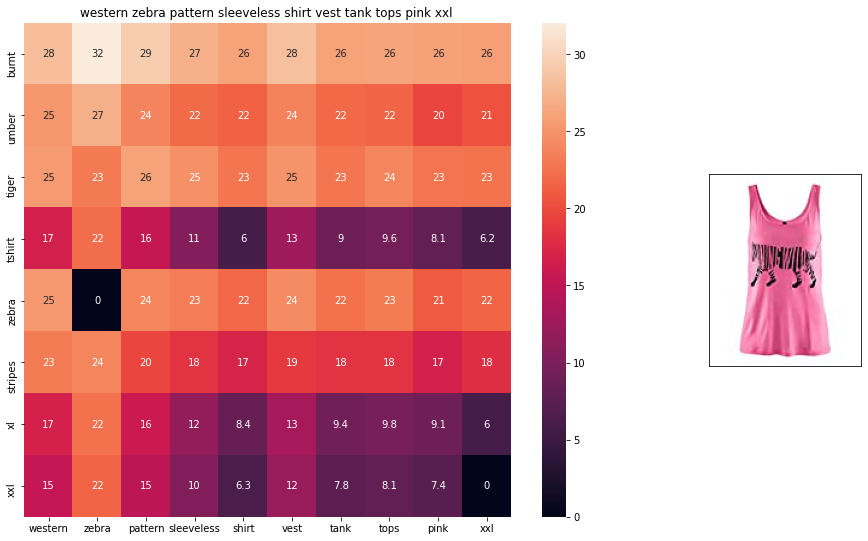

ASIN : B00Z6HEXWI
Brand : Black Temptation
euclidean distance from input : 6.6607366


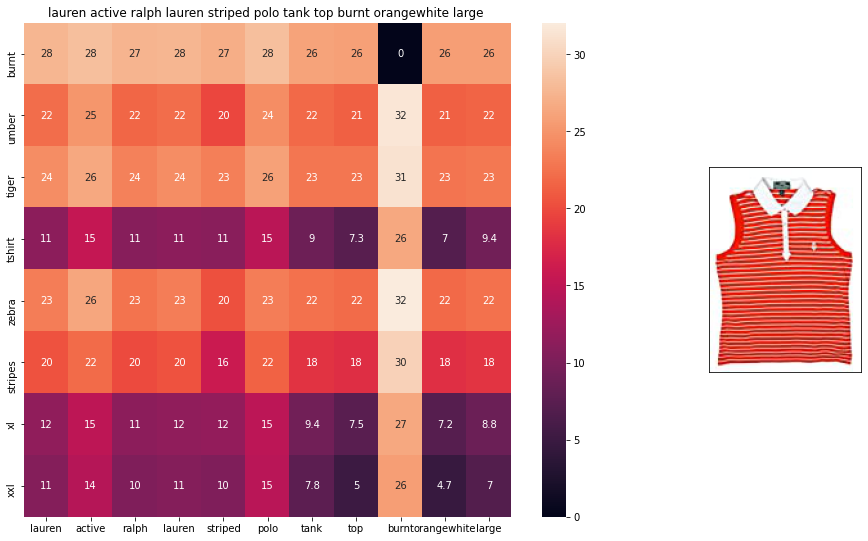

ASIN : B00ILGH5OY
Brand : Ralph Lauren Active
euclidean distance from input : 6.6839046


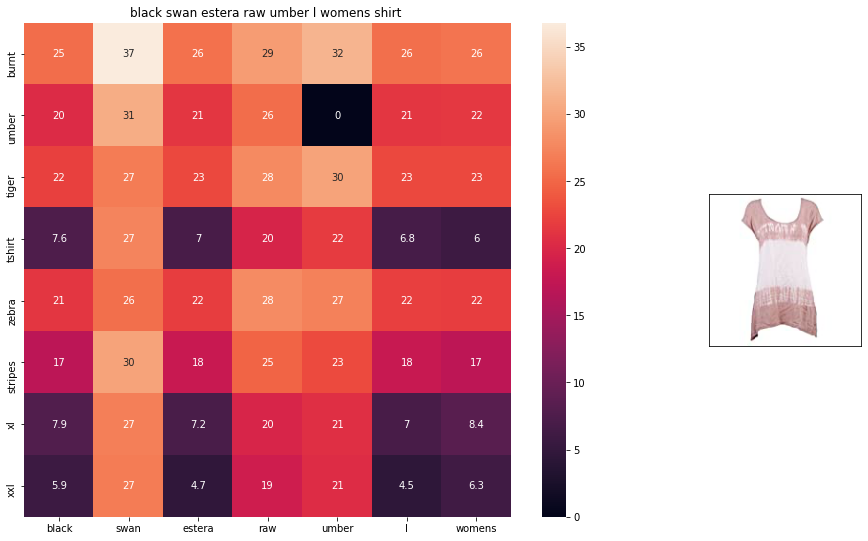

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 6.705763


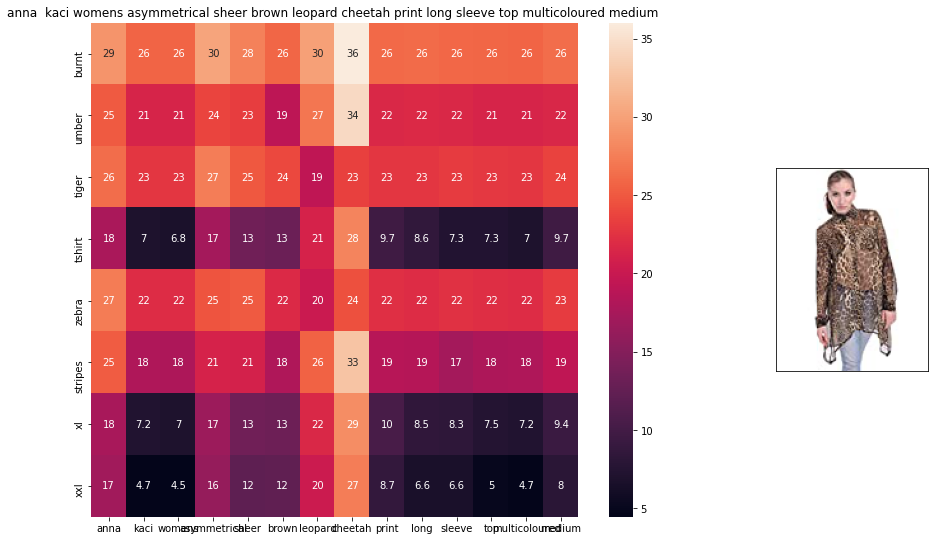

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 6.7061243


In [85]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)

# Weighted Similarity using Brand and Color

In [86]:
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [87]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
        
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)

    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    display_img(url, ax2, fig)
    
    plt.show()

In [88]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)

Output hidden; open in https://colab.research.google.com to view.

# Keras and TensorFlow to Extract Features

In [89]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

# Visual Features based product similarity

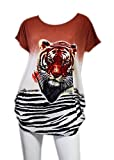

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 6.32596e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


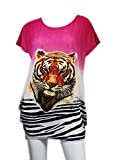

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.05017
Amazon Url: www.amzon.com/dp/B00JXQASS6


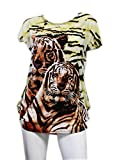

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261116
Amazon Url: www.amzon.com/dp/B00JXQCUIC


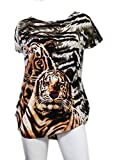

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000156
Amazon Url: www.amzon.com/dp/B00JXQCWTO


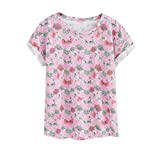

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38248
Amazon Url: www.amzon.com/dp/B071FCWD97


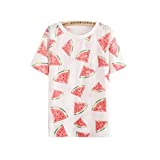

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.71842
Amazon Url: www.amzon.com/dp/B01JUNHBRM


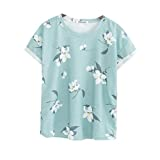

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.90206
Amazon Url: www.amzon.com/dp/B071SBCY9W


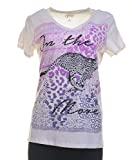

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046482
Amazon Url: www.amzon.com/dp/B01CUPYBM0


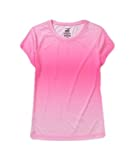

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101837
Amazon Url: www.amzon.com/dp/B01F7PHXY8


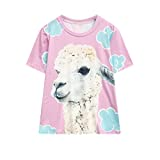

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118866
Amazon Url: www.amzon.com/dp/B01I80A93G


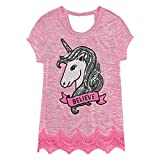

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13122
Amazon Url: www.amzon.com/dp/B0177DM70S


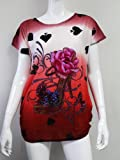

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16945
Amazon Url: www.amzon.com/dp/B00JV63QQE


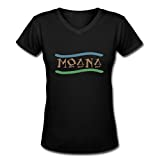

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.256786
Amazon Url: www.amzon.com/dp/B01LX6H43D


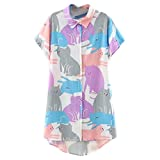

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265686
Amazon Url: www.amzon.com/dp/B01CR57YY0


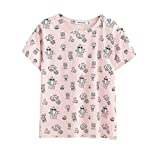

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362602
Amazon Url: www.amzon.com/dp/B071WYLBZS


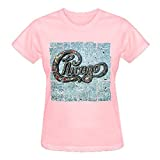

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383606
Amazon Url: www.amzon.com/dp/B01GXAZTRY


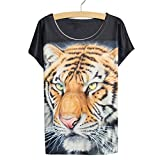

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449356
Amazon Url: www.amzon.com/dp/B010NN9RXO


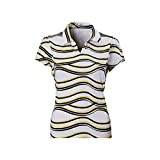

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.47889
Amazon Url: www.amzon.com/dp/B01MPX6IDX


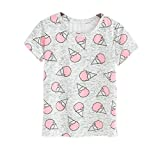

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557957
Amazon Url: www.amzon.com/dp/B0734GRKZL


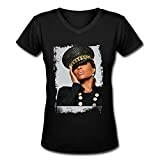

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614372
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [90]:
bottleneck_features_train = np.load('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/6k_data_cnn_features.npy')
asins = np.load('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/Appareal Recommendation/pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)

# ASSIGNMENT ASK 

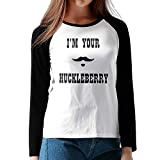

Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Euclidean Distance from input image: 3.09025781461969e-06
Amazon Url: www.amzon.com/dp/B01MG2JKHS


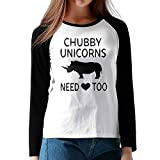

Product Title:  chubby unicorn need love 34sleeve raglan long sleeve 
Euclidean Distance from input image: 10.435585098356945
Amazon Url: www.amzon.com/dp/B01M67SUP1


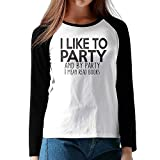

Product Title:  bibliophile literary like party 34sleeve raglan long sleeve 
Euclidean Distance from input image: 10.636690874878477
Amazon Url: www.amzon.com/dp/B01MFAZI9M


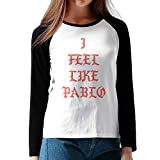

Product Title:  kanye west pinterest 34sleeve raglan long sleeve 
Euclidean Distance from input image: 10.997035369963392
Amazon Url: www.amzon.com/dp/B01MG2KZTK


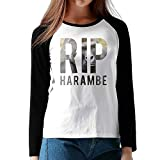

Product Title:  rip harambe cartoon 17th birthday killed 34sleeve raglan long sleeve 
Euclidean Distance from input image: 11.19805931100343
Amazon Url: www.amzon.com/dp/B01MPZYO3I


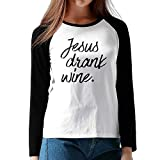

Product Title:  jesus drank wine 34sleeve raglan long sleeve 
Euclidean Distance from input image: 11.286864700407728
Amazon Url: www.amzon.com/dp/B01MG2KH61


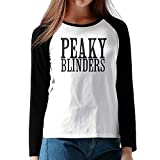

Product Title:  xjbd womens peaky drama series long sleeve blended baseball shirt size xl 
Euclidean Distance from input image: 11.46103263864015
Amazon Url: www.amzon.com/dp/B01M0B32NI


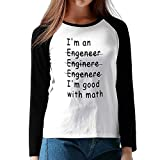

Product Title:  engineer good math 34sleeve raglan long sleeve 
Euclidean Distance from input image: 11.609403152556165
Amazon Url: www.amzon.com/dp/B01MG2PTEZ


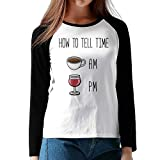

Product Title:  tell time pm 34sleeve raglan long sleeve 
Euclidean Distance from input image: 11.876585311979992
Amazon Url: www.amzon.com/dp/B01MFBI9GM


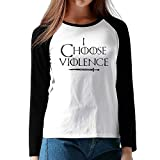

Product Title:  choose violence 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.031382605456672
Amazon Url: www.amzon.com/dp/B01MPZYO33


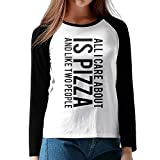

Product Title:  xjbd womens care pizza long sleeve blended baseball tshirts size 
Euclidean Distance from input image: 12.691571932617736
Amazon Url: www.amzon.com/dp/B01M0B32OT


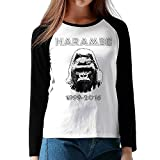

Product Title:  harambe gorilla 19992016 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.799911499059576
Amazon Url: www.amzon.com/dp/B01MG2K8BM


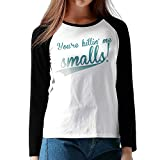

Product Title:  youre killing smalls 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.818527270142148
Amazon Url: www.amzon.com/dp/B01MFAZEVC


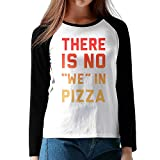

Product Title:  pizza 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.8656582642505
Amazon Url: www.amzon.com/dp/B01MPZYO3E


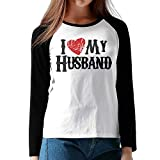

Product Title:  love husband 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.903641433806165
Amazon Url: www.amzon.com/dp/B01M30HH5A


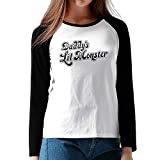

Product Title:  daddys little monster 34sleeve raglan long sleeve 
Euclidean Distance from input image: 12.971011886687025
Amazon Url: www.amzon.com/dp/B01M4MWVNV


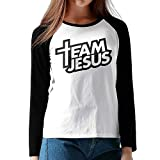

Product Title:  xjbd womens team jesus long sleeve blended baseball tshirts size xl 
Euclidean Distance from input image: 13.118819461991782
Amazon Url: www.amzon.com/dp/B01M0B6BLO


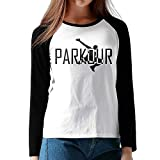

Product Title:  xjbd womens parkour dance long sleeve contrast raglan sleeve rib tshirt size l 
Euclidean Distance from input image: 13.167239608854993
Amazon Url: www.amzon.com/dp/B01M0B8EMX


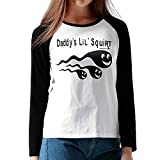

Product Title:  daddy lils squirt 34sleeve raglan long sleeve 
Euclidean Distance from input image: 13.217423782438978
Amazon Url: www.amzon.com/dp/B01MG2SGVM


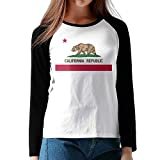

Product Title:  xjbd womens california star long sleeve blended baseball tshirts size l 
Euclidean Distance from input image: 13.259287143876547
Amazon Url: www.amzon.com/dp/B01M0B4WEW


In [91]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id,weighted_text,weighted_brand,weighted_color,weighted_image, num_results):
    doc_id = asins.index(df_asins[doc_id])

    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
   
    pairwise_dist = (weighted_text * idf_w2v_dist +  weighted_brand * brand_dist + weighted_color * color_dist + weighted_image * bottleneck_features_dist)/float(weighted_text + weighted_brand + weighted_color + weighted_image)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12562,50,30,20,100,20)

# PERFORMING DIFFERENT VALUES OF WEIGHTS

## WEIGHT TEXT = 100 , WEIGHT BRAND=50 , WEIGHT COLOR = 50 &  WEIGHT IMAGE=150 & DOCUMENT ID = 12560

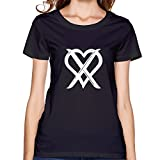

Product Title:  womens 7 ronaldo quotes love win tshirts xxl black short sleeve 
Euclidean Distance from input image: 2.584956819191575e-06
Amazon Url: www.amzon.com/dp/B01JSLCWXO


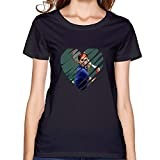

Product Title:  baby funny slim fit roger federer tshirt size xl color black 
Euclidean Distance from input image: 9.62749973852401
Amazon Url: www.amzon.com/dp/B00ZCFTMOS


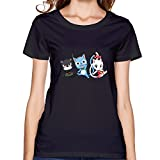

Product Title:  girls fairy tail exceed tee shirts black 
Euclidean Distance from input image: 10.081477359768495
Amazon Url: www.amzon.com/dp/B01L9F153U


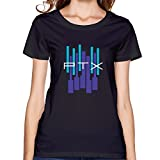

Product Title:  womens ptx pentatonix piano logo shirts black cool 
Euclidean Distance from input image: 10.686583037781888
Amazon Url: www.amzon.com/dp/B01JLSSCRY


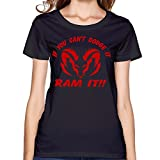

Product Title:  fashion womens dodge truck tee black size xs 
Euclidean Distance from input image: 11.011278559545282
Amazon Url: www.amzon.com/dp/B01IY8UBQ2


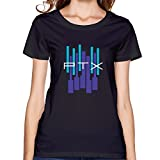

Product Title:  womens ptx pentatonix piano logo tee shirt black cool 
Euclidean Distance from input image: 11.074204933708229
Amazon Url: www.amzon.com/dp/B01JLSSLWA


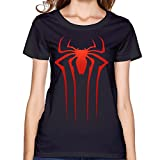

Product Title:  fashion womens amazing spider shirt black size l 
Euclidean Distance from input image: 11.3093916539816
Amazon Url: www.amzon.com/dp/B01INFD3WA


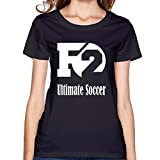

Product Title:  f2 freestylers ultimate soccer woman black short sleeve tshirt 
Euclidean Distance from input image: 11.314722290142313
Amazon Url: www.amzon.com/dp/B01J6WYQ48


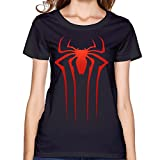

Product Title:  fashion womens amazing spider short sleeve black size xxl 
Euclidean Distance from input image: 11.371863450728318
Amazon Url: www.amzon.com/dp/B01INFDTV0


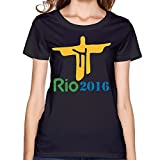

Product Title:  fashion womens jmj rio 2016 tee black size 
Euclidean Distance from input image: 11.517479731420282
Amazon Url: www.amzon.com/dp/B01INF7NKI


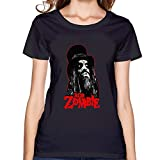

Product Title:  rob zombie shirts womens xxxl black 
Euclidean Distance from input image: 11.550858590365527
Amazon Url: www.amzon.com/dp/B01KFGQ700


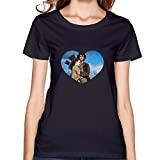

Product Title:  womens art ring spun cotton poldark teeshirt size color black 
Euclidean Distance from input image: 11.552871271896
Amazon Url: www.amzon.com/dp/B010FJ4GUA


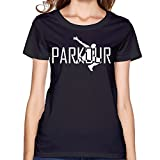

Product Title:  fashion womens parkour art sports short sleeve black size 
Euclidean Distance from input image: 11.695985935807764
Amazon Url: www.amzon.com/dp/B01J1AP3TM


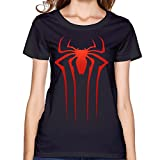

Product Title:  fashion womens amazing spider tees black size xl 
Euclidean Distance from input image: 11.736824864082045
Amazon Url: www.amzon.com/dp/B01INFDLJK


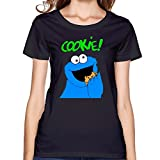

Product Title:  fashion womens sesame street cookie tshirts black size xl 
Euclidean Distance from input image: 11.810330770761798
Amazon Url: www.amzon.com/dp/B01IY8TXBQ


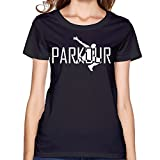

Product Title:  fashion womens parkour art sports tshirts black size xxl 
Euclidean Distance from input image: 11.828663856996448
Amazon Url: www.amzon.com/dp/B01J1AP6JO


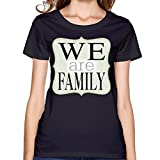

Product Title:  fashion womens family shirts black size xl 
Euclidean Distance from input image: 11.997498783056717
Amazon Url: www.amzon.com/dp/B01IY8UL4O


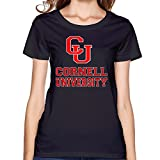

Product Title:  fashion womens cornell university cu logo shirt black size xs 
Euclidean Distance from input image: 12.017343968034327
Amazon Url: www.amzon.com/dp/B01IY8TBI6


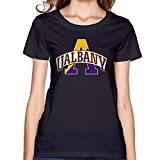

Product Title:  womens shirtsfashion university albany suny black sizem 
Euclidean Distance from input image: 12.023394906231871
Amazon Url: www.amzon.com/dp/B01ID3AXIO


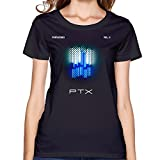

Product Title:  fashion womens ptx vol shirt black size xl 
Euclidean Distance from input image: 12.171689540421331
Amazon Url: www.amzon.com/dp/B01IY8T4S8


In [94]:
get_similar_products_cnn(12560,100,50,50,150,20)

## WEIGHT TEXT = 150 , WEIGHT BRAND=150 , WEIGHT COLOR = 150 &  WEIGHT IMAGE=150 & DOCUMENT ID = 12560

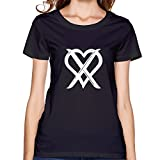

Product Title:  womens 7 ronaldo quotes love win tshirts xxl black short sleeve 
Euclidean Distance from input image: 1.5078914778617522e-06
Amazon Url: www.amzon.com/dp/B01JSLCWXO


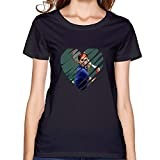

Product Title:  baby funny slim fit roger federer tshirt size xl color black 
Euclidean Distance from input image: 6.50953170794436
Amazon Url: www.amzon.com/dp/B00ZCFTMOS


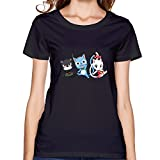

Product Title:  girls fairy tail exceed tee shirts black 
Euclidean Distance from input image: 6.930815156613098
Amazon Url: www.amzon.com/dp/B01L9F153U


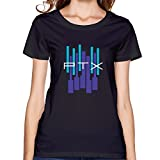

Product Title:  womens ptx pentatonix piano logo shirts black cool 
Euclidean Distance from input image: 7.294907970740702
Amazon Url: www.amzon.com/dp/B01JLSSCRY


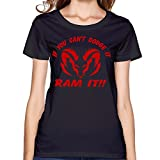

Product Title:  fashion womens dodge truck tee black size xs 
Euclidean Distance from input image: 7.50144076696466
Amazon Url: www.amzon.com/dp/B01IY8UBQ2


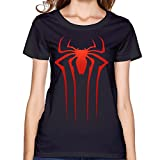

Product Title:  fashion womens amazing spider shirt black size l 
Euclidean Distance from input image: 7.504998423439151
Amazon Url: www.amzon.com/dp/B01INFD3WA


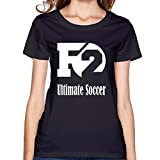

Product Title:  f2 freestylers ultimate soccer woman black short sleeve tshirt 
Euclidean Distance from input image: 7.589648386818058
Amazon Url: www.amzon.com/dp/B01J6WYQ48


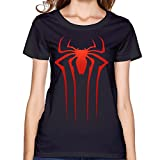

Product Title:  fashion womens amazing spider short sleeve black size xxl 
Euclidean Distance from input image: 7.599391002967265
Amazon Url: www.amzon.com/dp/B01INFDTV0


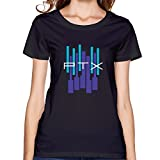

Product Title:  womens ptx pentatonix piano logo tee shirt black cool 
Euclidean Distance from input image: 7.63407728226414
Amazon Url: www.amzon.com/dp/B01JLSSLWA


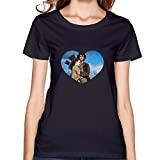

Product Title:  womens art ring spun cotton poldark teeshirt size color black 
Euclidean Distance from input image: 7.654730536364876
Amazon Url: www.amzon.com/dp/B010FJ4GUA


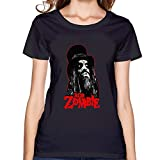

Product Title:  rob zombie shirts womens xxxl black 
Euclidean Distance from input image: 7.693023122332381
Amazon Url: www.amzon.com/dp/B01KFGQ700


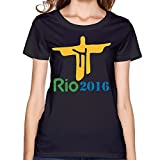

Product Title:  fashion womens jmj rio 2016 tee black size 
Euclidean Distance from input image: 7.731586132361796
Amazon Url: www.amzon.com/dp/B01INF7NKI


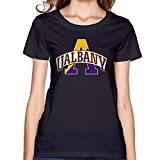

Product Title:  womens shirtsfashion university albany suny black sizem 
Euclidean Distance from input image: 7.761357345671398
Amazon Url: www.amzon.com/dp/B01ID3AXIO


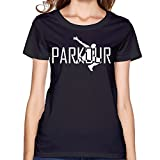

Product Title:  fashion womens parkour art sports short sleeve black size 
Euclidean Distance from input image: 7.84566205351645
Amazon Url: www.amzon.com/dp/B01J1AP3TM


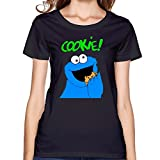

Product Title:  fashion womens sesame street cookie tshirts black size xl 
Euclidean Distance from input image: 7.8668312902394
Amazon Url: www.amzon.com/dp/B01IY8TXBQ


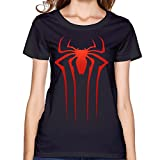

Product Title:  fashion womens amazing spider tees black size xl 
Euclidean Distance from input image: 7.879002533139672
Amazon Url: www.amzon.com/dp/B01INFDLJK


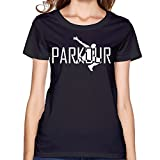

Product Title:  fashion womens parkour art sports tshirts black size xxl 
Euclidean Distance from input image: 8.001484890206022
Amazon Url: www.amzon.com/dp/B01J1AP6JO


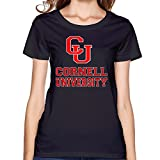

Product Title:  fashion womens cornell university cu logo shirt black size xs 
Euclidean Distance from input image: 8.002943649382335
Amazon Url: www.amzon.com/dp/B01IY8TBI6


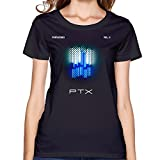

Product Title:  fashion womens ptx vol shirt black size xl 
Euclidean Distance from input image: 8.036980336687849
Amazon Url: www.amzon.com/dp/B01IY8T4S8


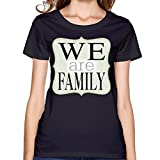

Product Title:  fashion womens family shirts black size xl 
Euclidean Distance from input image: 8.049266567452115
Amazon Url: www.amzon.com/dp/B01IY8UL4O


In [95]:
get_similar_products_cnn(12560,150,150,150,150,20)

## WEIGHT TEXT = 200 , WEIGHT BRAND=200 , WEIGHT COLOR = 200 &  WEIGHT IMAGE=200 & DOCUMENT ID = 12560

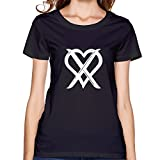

Product Title:  womens 7 ronaldo quotes love win tshirts xxl black short sleeve 
Euclidean Distance from input image: 1.5078915748745204e-06
Amazon Url: www.amzon.com/dp/B01JSLCWXO


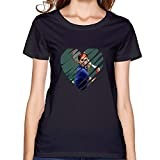

Product Title:  baby funny slim fit roger federer tshirt size xl color black 
Euclidean Distance from input image: 6.509531555356469
Amazon Url: www.amzon.com/dp/B00ZCFTMOS


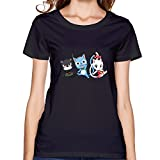

Product Title:  girls fairy tail exceed tee shirts black 
Euclidean Distance from input image: 6.930815054887837
Amazon Url: www.amzon.com/dp/B01L9F153U


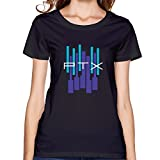

Product Title:  womens ptx pentatonix piano logo shirts black cool 
Euclidean Distance from input image: 7.294908072465962
Amazon Url: www.amzon.com/dp/B01JLSSCRY


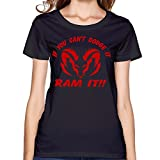

Product Title:  fashion womens dodge truck tee black size xs 
Euclidean Distance from input image: 7.501440665239399
Amazon Url: www.amzon.com/dp/B01IY8UBQ2


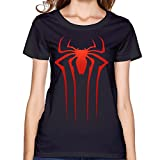

Product Title:  fashion womens amazing spider shirt black size l 
Euclidean Distance from input image: 7.504998626889672
Amazon Url: www.amzon.com/dp/B01INFD3WA


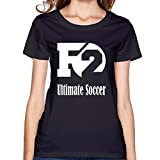

Product Title:  f2 freestylers ultimate soccer woman black short sleeve tshirt 
Euclidean Distance from input image: 7.589648285092798
Amazon Url: www.amzon.com/dp/B01J6WYQ48


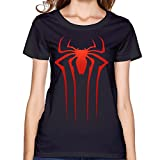

Product Title:  fashion womens amazing spider short sleeve black size xxl 
Euclidean Distance from input image: 7.599391104692525
Amazon Url: www.amzon.com/dp/B01INFDTV0


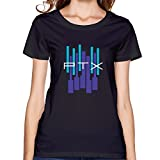

Product Title:  womens ptx pentatonix piano logo tee shirt black cool 
Euclidean Distance from input image: 7.634077231401509
Amazon Url: www.amzon.com/dp/B01JLSSLWA


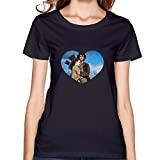

Product Title:  womens art ring spun cotton poldark teeshirt size color black 
Euclidean Distance from input image: 7.654730994128547
Amazon Url: www.amzon.com/dp/B010FJ4GUA


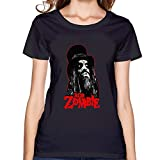

Product Title:  rob zombie shirts womens xxxl black 
Euclidean Distance from input image: 7.693023529233423
Amazon Url: www.amzon.com/dp/B01KFGQ700


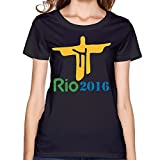

Product Title:  fashion womens jmj rio 2016 tee black size 
Euclidean Distance from input image: 7.731585623735493
Amazon Url: www.amzon.com/dp/B01INF7NKI


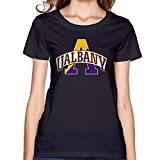

Product Title:  womens shirtsfashion university albany suny black sizem 
Euclidean Distance from input image: 7.761357345671399
Amazon Url: www.amzon.com/dp/B01ID3AXIO


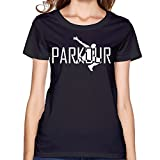

Product Title:  fashion womens parkour art sports short sleeve black size 
Euclidean Distance from input image: 7.84566185006593
Amazon Url: www.amzon.com/dp/B01J1AP3TM


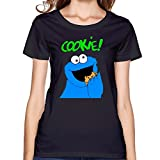

Product Title:  fashion womens sesame street cookie tshirts black size xl 
Euclidean Distance from input image: 7.866831137651509
Amazon Url: www.amzon.com/dp/B01IY8TXBQ


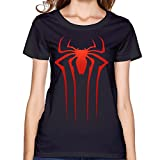

Product Title:  fashion womens amazing spider tees black size xl 
Euclidean Distance from input image: 7.8790026857275635
Amazon Url: www.amzon.com/dp/B01INFDLJK


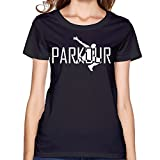

Product Title:  fashion womens parkour art sports tshirts black size xxl 
Euclidean Distance from input image: 8.0014846867555
Amazon Url: www.amzon.com/dp/B01J1AP6JO


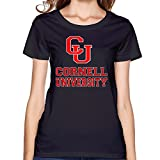

Product Title:  fashion womens cornell university cu logo shirt black size xs 
Euclidean Distance from input image: 8.002943878264173
Amazon Url: www.amzon.com/dp/B01IY8TBI6


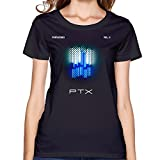

Product Title:  fashion womens ptx vol shirt black size xl 
Euclidean Distance from input image: 8.036980591001
Amazon Url: www.amzon.com/dp/B01IY8T4S8


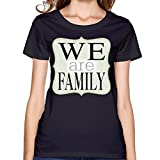

Product Title:  fashion womens family shirts black size xl 
Euclidean Distance from input image: 8.049266516589485
Amazon Url: www.amzon.com/dp/B01IY8UL4O


In [96]:
get_similar_products_cnn(12560,200,200,200,200,20)

# CONCLUSION :

1. WHEN WE TRY DIFFERENT WEIGHTS ON TEXT/BRAND/COLOR & IMAGE , THE SIMILAR PRODUCT RECOMMENDATION ALSO GETS CHANGE. THE ALGORITHM SHOWS DIFFERENT SIMILAR PRODUCTS
2. WHEN WE TRY DIFFERENT WEIGHTS , THE EUCLIDEAN DISTANCE ALSO GET REDUCES FOR THE RECOMMENDED PRODUCTS